In [40]:
import random
import numpy as np
import matplotlib.pyplot as pl
from sklearn.utils import class_weight
import tensorflow as tf
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import Sequential, activations, Input
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import (
    BatchNormalization, Activation, SpatialDropout2D, GlobalAveragePooling2D,
    Dense, Dropout, Flatten,
    Conv2D, MaxPooling2D, SeparableConv2D
)
from tensorflow.keras.layers.experimental.preprocessing import Rescaling

# Import project utils scripts
import os
import sys

src_path = os.path.abspath(os.path.join('../src/'))

if src_path not in sys.path:
    sys.path.append(src_path)

from visualizationUtils import plot_confusion_matrix
from statisticsUtils import recall_precision_fscore_from_confusion_matrix
from lossesUtils import categorical_focal_loss
from bandUtils import Band 
from labelsUtils import Label
from rasterUtils import make_dataset_from_raster_files
from regionUtils import (
    vietnam_labels_coordinates,
    sumatra_south_labels_coordinates,
    sumatra_center_labels_coordinates,
    sulawesi_labels_coordinates,
    para_north_labels_coordinates,
    para_center_labels_coordinates,
    ocotopeque_labels_coordinates,
    ghana_labels_coordinates,
    borneo_labels_coordinates
)
from convNetUtils import images_from_dataset, labels_from_dataset, cross_validation

In [2]:
DATA_ROOT_PATH = '../data/'
NB_PIXEL_AROUND = 4
BANDS = [
    Band.COASTAL_AEROSOL.value, 
    Band.BLUE.value, 
    Band.GREEN.value, 
    Band.RED.value, 
    Band.NIR.value, 
    Band.SWIR1.value, 
    Band.SWIR2.value, 
]

In [3]:
# create a dataset per region
datasets = []

labels_coordinates_list = [
    sumatra_south_labels_coordinates(),
    sumatra_center_labels_coordinates(),
    para_north_labels_coordinates(),
    para_center_labels_coordinates(),
    borneo_labels_coordinates(),
    sulawesi_labels_coordinates(),
    ghana_labels_coordinates(),
    ocotopeque_labels_coordinates()
]

datasets_name = [
    'Sumatra_south_2018_whole_year_collection2',
    'Sumatra_center_2018_whole_year_collection2',
    'Para_north_2018_whole_year_collection2',
    'Para_center_2018_whole_year_collection2',
    'Borneo_2018_whole_year_collection2',
    'Sulawesi_2018_whole_year_collection2',
    'Ghana_2019_whole_year_collection2',
    'Ocotopeque_2018_whole_year_collection2'
]


for i, dataset_name in enumerate(datasets_name):
    labels_coordinates = labels_coordinates_list[i]
    labels = [Label(label) for label in labels_coordinates if len(labels_coordinates[label]) > 5]
    labels_names = [label.name for label in labels]
    
    dataset_args = dict(
        labels = labels,
        raster_paths = [DATA_ROOT_PATH + dataset_name + '/merged.tif'],
        labels_coordinates_list = [labels_coordinates],
        nb_pixel_around = NB_PIXEL_AROUND
    )

    dataset = make_dataset_from_raster_files(**dataset_args)
    datasets.append((labels_names, dataset))

In [7]:
size_min_datasets = min([len(dataset[1]) for dataset in datasets])

In [11]:
def generate_task(datasets, nb_images=None):
    # choose one dastaset randomly
    task_idx = random.choice(np.arange(len(datasets)))
    
    labels_names, dataset = datasets[task_idx]

    np.random.shuffle(dataset)
    
    if nb_images is not None:
        dataset = random.choices(dataset, k=nb_images)

    X_train = images_from_dataset(dataset, BANDS)
    y_train = labels_from_dataset(dataset, labels_names)
    Y_train = to_categorical(y_train, num_classes=len(labels_names))
        
    return X_train, y_train, Y_train, labels_names, task_idx, 

In [14]:
import statistics

In [25]:
image_width = 9
image_height = 9
image_depth = len(BANDS)

# define hyperparameters
learning_rate = 0.001
momentum = 0.9
meta_step_size = 0.25
nb_iterations = 2500
nb_inner_iters = 5
minibatches_size = 32

# define model
inputs = Input(shape=(image_width, image_height, image_depth))
layers = Rescaling(2.75e-05, offset=-0.2)(inputs) # Landsat 8 collection 2 rescaling
layers = BatchNormalization()(layers)
layers = Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation="relu")(layers)
layers = Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation="relu")(layers)
layers = MaxPooling2D(pool_size=(3, 3))(layers)
layers = Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu")(layers)
layers = Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu")(layers)
layers = MaxPooling2D(pool_size=(3, 3))(layers)
layers = SpatialDropout2D(0.25)(layers)
layers = GlobalAveragePooling2D()(layers)
layers = Dense(128, activation='relu')(layers)
layers = Dropout(0.25)(layers)
label_output = Dense(len(labels_names), activation='softmax', name="label")(layers)

model = Model(inputs=inputs, outputs=label_output)

# create a dictionary that will keep in memory the output layer weights of each task
tasks_output_weights = dict()

for iteration in range(nb_iterations):
    print(f"iteration: {iteration + 1}/{nb_iterations}")
    
    # Generate a new task
    X_train, _, Y_train, labels_names, task_idx = generate_task(datasets, size_min_datasets)
        
    print(f"task id: {task_idx}")
    print(f"task size: {len(X_train)}")
    
    # Create model with an new output layer for this task
    label_output = Dense(len(labels_names), activation='softmax', name="label")(model.layers[-2].output)
    model = Model(inputs=inputs, outputs=label_output)
    model.compile()
    optimizer = SGD(learning_rate=learning_rate, momentum=momentum, clipnorm=1.0)
    
    # If task as already been trained on, set back the previous weights of the output layer 
    if task_idx in tasks_output_weights:
        model.layers[-1].set_weights(tasks_output_weights[task_idx])        
            
    # Save old weights
    old_weights = model.get_weights()
        
    # Train
    for inner_iter in range(nb_inner_iters):
        print(f"inner_iter: {inner_iter + 1}/{nb_inner_iters}")
        
        for start in range(0, len(X_train), minibatches_size):
            batch_x = X_train[start : start + minibatches_size]
            batch_y = Y_train[start : start + minibatches_size]

            with tf.GradientTape() as tape:
                # Feed forward
                preds = model(batch_x)
                                
                # Compute batch loss
                # loss = categorical_crossentropy(batch_y, preds)
                loss = categorical_focal_loss([[.25] * len(labels_names)])(batch_y, preds)
            
            # Compute gradient
            gradients = tape.gradient(loss, model.trainable_weights)
            
            # Update model's weights
            optimizer.apply_gradients(zip(gradients, model.trainable_weights))
                    
    new_weights = model.get_weights()
    
    print("loss: ", loss)
    
    # Update weights
    for weight in range(len(new_weights)):
        learning_rate = (1 - iteration / nb_iterations) * meta_step_size

        new_weights[weight] = old_weights[weight] + (
            (new_weights[weight] - old_weights[weight]) * learning_rate
        )
        
    # After the meta-learning step, reload the newly-trained weights into the model.
    model.set_weights(new_weights)
    
    # Save task's output layer weights
    tasks_output_weights[task_idx] = model.layers[-1].get_weights()

iteration: 1/2500
task id: 7
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.5669565, shape=(), dtype=float32)
iteration: 2/2500
task id: 4
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.21772404, shape=(), dtype=float32)
iteration: 3/2500
task id: 4
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.20766075, shape=(), dtype=float32)
iteration: 4/2500
task id: 5
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.47835946, shape=(), dtype=float32)
iteration: 5/2500
task id: 2
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.1945181, shape=(), dtype=float32)
iteration: 6/2500
task id: 5
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter

loss:  tf.Tensor(0.5375206, shape=(), dtype=float32)
iteration: 48/2500
task id: 1
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.29226205, shape=(), dtype=float32)
iteration: 49/2500
task id: 3
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.27930582, shape=(), dtype=float32)
iteration: 50/2500
task id: 1
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.24400026, shape=(), dtype=float32)
iteration: 51/2500
task id: 6
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.6058052, shape=(), dtype=float32)
iteration: 52/2500
task id: 2
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.2809771, shape=(), dtype=float32)
iteration: 53/2500
task id: 1
task size: 89
inner_iter: 1/5

loss:  tf.Tensor(0.28737724, shape=(), dtype=float32)
iteration: 95/2500
task id: 3
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.12260716, shape=(), dtype=float32)
iteration: 96/2500
task id: 4
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.12793984, shape=(), dtype=float32)
iteration: 97/2500
task id: 5
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.525011, shape=(), dtype=float32)
iteration: 98/2500
task id: 4
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.12269539, shape=(), dtype=float32)
iteration: 99/2500
task id: 7
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.35327634, shape=(), dtype=float32)
iteration: 100/2500
task id: 7
task size: 89
inner_iter: 1

loss:  tf.Tensor(0.49684098, shape=(), dtype=float32)
iteration: 141/2500
task id: 2
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.07074144, shape=(), dtype=float32)
iteration: 142/2500
task id: 3
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.06745587, shape=(), dtype=float32)
iteration: 143/2500
task id: 1
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.28692538, shape=(), dtype=float32)
iteration: 144/2500
task id: 7
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.1806544, shape=(), dtype=float32)
iteration: 145/2500
task id: 7
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.11002782, shape=(), dtype=float32)
iteration: 146/2500
task id: 3
task size: 89
inner_i

loss:  tf.Tensor(0.23219965, shape=(), dtype=float32)
iteration: 187/2500
task id: 3
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.049626917, shape=(), dtype=float32)
iteration: 188/2500
task id: 5
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.30096856, shape=(), dtype=float32)
iteration: 189/2500
task id: 1
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.15641539, shape=(), dtype=float32)
iteration: 190/2500
task id: 5
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.3046996, shape=(), dtype=float32)
iteration: 191/2500
task id: 2
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.00031153587, shape=(), dtype=float32)
iteration: 192/2500
task id: 4
task size: 89
inn

loss:  tf.Tensor(0.03769945, shape=(), dtype=float32)
iteration: 233/2500
task id: 7
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.07041995, shape=(), dtype=float32)
iteration: 234/2500
task id: 7
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.11729807, shape=(), dtype=float32)
iteration: 235/2500
task id: 4
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.03749364, shape=(), dtype=float32)
iteration: 236/2500
task id: 7
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.11505555, shape=(), dtype=float32)
iteration: 237/2500
task id: 2
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.020428855, shape=(), dtype=float32)
iteration: 238/2500
task id: 2
task size: 89
inner

loss:  tf.Tensor(0.023692, shape=(), dtype=float32)
iteration: 279/2500
task id: 4
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.031574167, shape=(), dtype=float32)
iteration: 280/2500
task id: 5
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.13615778, shape=(), dtype=float32)
iteration: 281/2500
task id: 7
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.054676656, shape=(), dtype=float32)
iteration: 282/2500
task id: 1
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.25275728, shape=(), dtype=float32)
iteration: 283/2500
task id: 1
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.17921582, shape=(), dtype=float32)
iteration: 284/2500
task id: 2
task size: 89
inner_

loss:  tf.Tensor(0.2730366, shape=(), dtype=float32)
iteration: 325/2500
task id: 4
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.015029516, shape=(), dtype=float32)
iteration: 326/2500
task id: 4
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.023248784, shape=(), dtype=float32)
iteration: 327/2500
task id: 5
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.17036283, shape=(), dtype=float32)
iteration: 328/2500
task id: 4
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.0065624584, shape=(), dtype=float32)
iteration: 329/2500
task id: 4
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.009220677, shape=(), dtype=float32)
iteration: 330/2500
task id: 0
task size: 89
in

loss:  tf.Tensor(0.08664758, shape=(), dtype=float32)
iteration: 371/2500
task id: 3
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.055864107, shape=(), dtype=float32)
iteration: 372/2500
task id: 4
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.002726952, shape=(), dtype=float32)
iteration: 373/2500
task id: 6
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.4283981, shape=(), dtype=float32)
iteration: 374/2500
task id: 5
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.20915848, shape=(), dtype=float32)
iteration: 375/2500
task id: 6
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.40662318, shape=(), dtype=float32)
iteration: 376/2500
task id: 7
task size: 89
inner

loss:  tf.Tensor(0.0025114277, shape=(), dtype=float32)
iteration: 417/2500
task id: 6
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.18379833, shape=(), dtype=float32)
iteration: 418/2500
task id: 2
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.0005014295, shape=(), dtype=float32)
iteration: 419/2500
task id: 3
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.021401482, shape=(), dtype=float32)
iteration: 420/2500
task id: 5
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.109866075, shape=(), dtype=float32)
iteration: 421/2500
task id: 3
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.10057227, shape=(), dtype=float32)
iteration: 422/2500
task id: 1
task size: 89


loss:  tf.Tensor(0.029228143, shape=(), dtype=float32)
iteration: 463/2500
task id: 0
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.056610454, shape=(), dtype=float32)
iteration: 464/2500
task id: 4
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.0019793569, shape=(), dtype=float32)
iteration: 465/2500
task id: 2
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.0061640423, shape=(), dtype=float32)
iteration: 466/2500
task id: 0
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.084162496, shape=(), dtype=float32)
iteration: 467/2500
task id: 1
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.02788269, shape=(), dtype=float32)
iteration: 468/2500
task id: 0
task size: 89

loss:  tf.Tensor(0.010762922, shape=(), dtype=float32)
iteration: 509/2500
task id: 6
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.40216014, shape=(), dtype=float32)
iteration: 510/2500
task id: 4
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.012631316, shape=(), dtype=float32)
iteration: 511/2500
task id: 4
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.0014655185, shape=(), dtype=float32)
iteration: 512/2500
task id: 7
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.027150843, shape=(), dtype=float32)
iteration: 513/2500
task id: 4
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.0020482559, shape=(), dtype=float32)
iteration: 514/2500
task id: 3
task size: 89

loss:  tf.Tensor(0.012551955, shape=(), dtype=float32)
iteration: 555/2500
task id: 1
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.067283325, shape=(), dtype=float32)
iteration: 556/2500
task id: 3
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.010437019, shape=(), dtype=float32)
iteration: 557/2500
task id: 1
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.094674245, shape=(), dtype=float32)
iteration: 558/2500
task id: 5
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.022137538, shape=(), dtype=float32)
iteration: 559/2500
task id: 4
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.00019429663, shape=(), dtype=float32)
iteration: 560/2500
task id: 1
task size: 8

loss:  tf.Tensor(0.10123625, shape=(), dtype=float32)
iteration: 601/2500
task id: 6
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.21764903, shape=(), dtype=float32)
iteration: 602/2500
task id: 2
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.008487274, shape=(), dtype=float32)
iteration: 603/2500
task id: 5
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.009943916, shape=(), dtype=float32)
iteration: 604/2500
task id: 0
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.047104463, shape=(), dtype=float32)
iteration: 605/2500
task id: 5
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.02711051, shape=(), dtype=float32)
iteration: 606/2500
task id: 1
task size: 89
inn

loss:  tf.Tensor(0.021576812, shape=(), dtype=float32)
iteration: 647/2500
task id: 3
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.05343871, shape=(), dtype=float32)
iteration: 648/2500
task id: 1
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.062716916, shape=(), dtype=float32)
iteration: 649/2500
task id: 7
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.04318448, shape=(), dtype=float32)
iteration: 650/2500
task id: 7
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.016102035, shape=(), dtype=float32)
iteration: 651/2500
task id: 7
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.02451334, shape=(), dtype=float32)
iteration: 652/2500
task id: 4
task size: 89
inn

loss:  tf.Tensor(0.08879274, shape=(), dtype=float32)
iteration: 693/2500
task id: 7
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.016587522, shape=(), dtype=float32)
iteration: 694/2500
task id: 1
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.037605766, shape=(), dtype=float32)
iteration: 695/2500
task id: 2
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.0009651727, shape=(), dtype=float32)
iteration: 696/2500
task id: 3
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.0047675134, shape=(), dtype=float32)
iteration: 697/2500
task id: 6
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.20537908, shape=(), dtype=float32)
iteration: 698/2500
task id: 4
task size: 89


loss:  tf.Tensor(0.017004538, shape=(), dtype=float32)
iteration: 739/2500
task id: 4
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.00013622497, shape=(), dtype=float32)
iteration: 740/2500
task id: 5
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.027097005, shape=(), dtype=float32)
iteration: 741/2500
task id: 3
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.03678921, shape=(), dtype=float32)
iteration: 742/2500
task id: 2
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.003403581, shape=(), dtype=float32)
iteration: 743/2500
task id: 0
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.009119497, shape=(), dtype=float32)
iteration: 744/2500
task id: 7
task size: 89

loss:  tf.Tensor(0.0056137466, shape=(), dtype=float32)
iteration: 785/2500
task id: 1
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.04028809, shape=(), dtype=float32)
iteration: 786/2500
task id: 1
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.0155220935, shape=(), dtype=float32)
iteration: 787/2500
task id: 2
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.00011723997, shape=(), dtype=float32)
iteration: 788/2500
task id: 2
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.0005514349, shape=(), dtype=float32)
iteration: 789/2500
task id: 0
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.14372067, shape=(), dtype=float32)
iteration: 790/2500
task id: 6
task size: 

loss:  tf.Tensor(0.016966555, shape=(), dtype=float32)
iteration: 831/2500
task id: 3
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.0017372288, shape=(), dtype=float32)
iteration: 832/2500
task id: 5
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.04100694, shape=(), dtype=float32)
iteration: 833/2500
task id: 7
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.012247353, shape=(), dtype=float32)
iteration: 834/2500
task id: 0
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.012474811, shape=(), dtype=float32)
iteration: 835/2500
task id: 1
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.059741434, shape=(), dtype=float32)
iteration: 836/2500
task id: 6
task size: 89


loss:  tf.Tensor(0.0075881183, shape=(), dtype=float32)
iteration: 877/2500
task id: 1
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.006282817, shape=(), dtype=float32)
iteration: 878/2500
task id: 4
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.00013079432, shape=(), dtype=float32)
iteration: 879/2500
task id: 2
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.0029742045, shape=(), dtype=float32)
iteration: 880/2500
task id: 6
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.07488097, shape=(), dtype=float32)
iteration: 881/2500
task id: 7
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.008464677, shape=(), dtype=float32)
iteration: 882/2500
task id: 3
task size: 

inner_iter: 5/5
loss:  tf.Tensor(0.00063510524, shape=(), dtype=float32)
iteration: 923/2500
task id: 0
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.0104269, shape=(), dtype=float32)
iteration: 924/2500
task id: 3
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.014199869, shape=(), dtype=float32)
iteration: 925/2500
task id: 3
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.00046244054, shape=(), dtype=float32)
iteration: 926/2500
task id: 4
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(7.50937e-05, shape=(), dtype=float32)
iteration: 927/2500
task id: 7
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.010724903, shape=(), dtype=float32)
iteration: 928/2500
task id

inner_iter: 5/5
loss:  tf.Tensor(0.0051224767, shape=(), dtype=float32)
iteration: 969/2500
task id: 4
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(9.421358e-05, shape=(), dtype=float32)
iteration: 970/2500
task id: 5
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.0043489053, shape=(), dtype=float32)
iteration: 971/2500
task id: 0
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.008798288, shape=(), dtype=float32)
iteration: 972/2500
task id: 5
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.024388738, shape=(), dtype=float32)
iteration: 973/2500
task id: 2
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.00538607, shape=(), dtype=float32)
iteration: 974/2500
task id

inner_iter: 5/5
loss:  tf.Tensor(0.00053340534, shape=(), dtype=float32)
iteration: 1015/2500
task id: 6
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.042654306, shape=(), dtype=float32)
iteration: 1016/2500
task id: 5
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.032912515, shape=(), dtype=float32)
iteration: 1017/2500
task id: 0
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.0025321662, shape=(), dtype=float32)
iteration: 1018/2500
task id: 4
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.00011154743, shape=(), dtype=float32)
iteration: 1019/2500
task id: 3
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.0037806367, shape=(), dtype=float32)
iteration: 1020/25

inner_iter: 5/5
loss:  tf.Tensor(0.0060069673, shape=(), dtype=float32)
iteration: 1061/2500
task id: 0
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.009185583, shape=(), dtype=float32)
iteration: 1062/2500
task id: 7
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.0035895077, shape=(), dtype=float32)
iteration: 1063/2500
task id: 3
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.00036444995, shape=(), dtype=float32)
iteration: 1064/2500
task id: 0
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.0014722033, shape=(), dtype=float32)
iteration: 1065/2500
task id: 2
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.0013123839, shape=(), dtype=float32)
iteration: 1066/25

inner_iter: 5/5
loss:  tf.Tensor(0.00010302257, shape=(), dtype=float32)
iteration: 1107/2500
task id: 6
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.073069066, shape=(), dtype=float32)
iteration: 1108/2500
task id: 0
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.008799367, shape=(), dtype=float32)
iteration: 1109/2500
task id: 2
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.00041019078, shape=(), dtype=float32)
iteration: 1110/2500
task id: 5
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.005927271, shape=(), dtype=float32)
iteration: 1111/2500
task id: 0
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.01782794, shape=(), dtype=float32)
iteration: 1112/2500


inner_iter: 5/5
loss:  tf.Tensor(0.00011698072, shape=(), dtype=float32)
iteration: 1153/2500
task id: 1
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.02590876, shape=(), dtype=float32)
iteration: 1154/2500
task id: 3
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.0009480545, shape=(), dtype=float32)
iteration: 1155/2500
task id: 1
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.01119379, shape=(), dtype=float32)
iteration: 1156/2500
task id: 2
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.00086334185, shape=(), dtype=float32)
iteration: 1157/2500
task id: 4
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.0004721428, shape=(), dtype=float32)
iteration: 1158/2500

inner_iter: 5/5
loss:  tf.Tensor(0.023268238, shape=(), dtype=float32)
iteration: 1199/2500
task id: 5
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.023080125, shape=(), dtype=float32)
iteration: 1200/2500
task id: 7
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.0060219574, shape=(), dtype=float32)
iteration: 1201/2500
task id: 4
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(5.2855514e-05, shape=(), dtype=float32)
iteration: 1202/2500
task id: 5
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.0014163669, shape=(), dtype=float32)
iteration: 1203/2500
task id: 7
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.0014355822, shape=(), dtype=float32)
iteration: 1204/250

inner_iter: 5/5
loss:  tf.Tensor(0.0050324397, shape=(), dtype=float32)
iteration: 1245/2500
task id: 1
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.012833267, shape=(), dtype=float32)
iteration: 1246/2500
task id: 7
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.012129753, shape=(), dtype=float32)
iteration: 1247/2500
task id: 6
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.008892179, shape=(), dtype=float32)
iteration: 1248/2500
task id: 4
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.00010476018, shape=(), dtype=float32)
iteration: 1249/2500
task id: 1
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.003295459, shape=(), dtype=float32)
iteration: 1250/2500


inner_iter: 5/5
loss:  tf.Tensor(0.046909496, shape=(), dtype=float32)
iteration: 1291/2500
task id: 4
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(1.8701274e-05, shape=(), dtype=float32)
iteration: 1292/2500
task id: 6
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.020645458, shape=(), dtype=float32)
iteration: 1293/2500
task id: 4
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(7.277346e-05, shape=(), dtype=float32)
iteration: 1294/2500
task id: 2
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.0017617834, shape=(), dtype=float32)
iteration: 1295/2500
task id: 5
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.021419324, shape=(), dtype=float32)
iteration: 1296/2500

inner_iter: 5/5
loss:  tf.Tensor(0.000106512445, shape=(), dtype=float32)
iteration: 1337/2500
task id: 1
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.007068348, shape=(), dtype=float32)
iteration: 1338/2500
task id: 4
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(9.490354e-05, shape=(), dtype=float32)
iteration: 1339/2500
task id: 1
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.006359238, shape=(), dtype=float32)
iteration: 1340/2500
task id: 6
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.016883744, shape=(), dtype=float32)
iteration: 1341/2500
task id: 0
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.016306497, shape=(), dtype=float32)
iteration: 1342/2500

inner_iter: 5/5
loss:  tf.Tensor(0.011752272, shape=(), dtype=float32)
iteration: 1383/2500
task id: 1
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.008942771, shape=(), dtype=float32)
iteration: 1384/2500
task id: 1
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.060037974, shape=(), dtype=float32)
iteration: 1385/2500
task id: 2
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(6.7530644e-05, shape=(), dtype=float32)
iteration: 1386/2500
task id: 6
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.0074455105, shape=(), dtype=float32)
iteration: 1387/2500
task id: 7
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.0037040028, shape=(), dtype=float32)
iteration: 1388/2500

inner_iter: 5/5
loss:  tf.Tensor(7.26241e-05, shape=(), dtype=float32)
iteration: 1429/2500
task id: 4
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(7.275694e-05, shape=(), dtype=float32)
iteration: 1430/2500
task id: 6
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.07324279, shape=(), dtype=float32)
iteration: 1431/2500
task id: 2
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.0012266517, shape=(), dtype=float32)
iteration: 1432/2500
task id: 5
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.0045635263, shape=(), dtype=float32)
iteration: 1433/2500
task id: 4
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(2.9366847e-05, shape=(), dtype=float32)
iteration: 1434/2500

inner_iter: 5/5
loss:  tf.Tensor(0.020735316, shape=(), dtype=float32)
iteration: 1475/2500
task id: 2
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.00015105095, shape=(), dtype=float32)
iteration: 1476/2500
task id: 3
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.010802788, shape=(), dtype=float32)
iteration: 1477/2500
task id: 2
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.00013163917, shape=(), dtype=float32)
iteration: 1478/2500
task id: 1
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.013261255, shape=(), dtype=float32)
iteration: 1479/2500
task id: 1
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.003673909, shape=(), dtype=float32)
iteration: 1480/2500

inner_iter: 5/5
loss:  tf.Tensor(0.00022993585, shape=(), dtype=float32)
iteration: 1521/2500
task id: 3
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.002086581, shape=(), dtype=float32)
iteration: 1522/2500
task id: 6
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.025534682, shape=(), dtype=float32)
iteration: 1523/2500
task id: 1
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.0020065855, shape=(), dtype=float32)
iteration: 1524/2500
task id: 1
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.0043623773, shape=(), dtype=float32)
iteration: 1525/2500
task id: 4
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(4.2116757e-05, shape=(), dtype=float32)
iteration: 1526/25

inner_iter: 5/5
loss:  tf.Tensor(0.0021219896, shape=(), dtype=float32)
iteration: 1567/2500
task id: 4
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(5.8074766e-05, shape=(), dtype=float32)
iteration: 1568/2500
task id: 4
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(2.0253448e-05, shape=(), dtype=float32)
iteration: 1569/2500
task id: 1
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.012442234, shape=(), dtype=float32)
iteration: 1570/2500
task id: 4
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(5.197681e-05, shape=(), dtype=float32)
iteration: 1571/2500
task id: 4
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(9.75691e-06, shape=(), dtype=float32)
iteration: 1572/25

inner_iter: 5/5
loss:  tf.Tensor(0.0071543413, shape=(), dtype=float32)
iteration: 1613/2500
task id: 1
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.0048491852, shape=(), dtype=float32)
iteration: 1614/2500
task id: 1
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.007496926, shape=(), dtype=float32)
iteration: 1615/2500
task id: 6
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.027272375, shape=(), dtype=float32)
iteration: 1616/2500
task id: 2
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.00030740938, shape=(), dtype=float32)
iteration: 1617/2500
task id: 0
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.003923572, shape=(), dtype=float32)
iteration: 1618/2500

inner_iter: 5/5
loss:  tf.Tensor(0.0064282273, shape=(), dtype=float32)
iteration: 1659/2500
task id: 2
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.0011841148, shape=(), dtype=float32)
iteration: 1660/2500
task id: 6
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.02648095, shape=(), dtype=float32)
iteration: 1661/2500
task id: 1
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.003296002, shape=(), dtype=float32)
iteration: 1662/2500
task id: 7
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.004006476, shape=(), dtype=float32)
iteration: 1663/2500
task id: 1
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.002756645, shape=(), dtype=float32)
iteration: 1664/2500
ta

inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(4.6632336e-05, shape=(), dtype=float32)
iteration: 1705/2500
task id: 5
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.008976103, shape=(), dtype=float32)
iteration: 1706/2500
task id: 0
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.0052759033, shape=(), dtype=float32)
iteration: 1707/2500
task id: 4
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(5.4429584e-05, shape=(), dtype=float32)
iteration: 1708/2500
task id: 2
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.00026656568, shape=(), dtype=float32)
iteration: 1709/2500
task id: 4
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(3.5134286e-05, shape=(), dtype=float32)

inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.0061504515, shape=(), dtype=float32)
iteration: 1751/2500
task id: 5
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.0018585781, shape=(), dtype=float32)
iteration: 1752/2500
task id: 5
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.0012352319, shape=(), dtype=float32)
iteration: 1753/2500
task id: 1
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.00765427, shape=(), dtype=float32)
iteration: 1754/2500
task id: 3
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.004956217, shape=(), dtype=float32)
iteration: 1755/2500
task id: 5
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.002003258, shape=(), dtype=float32)
iterat

inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.00047133706, shape=(), dtype=float32)
iteration: 1797/2500
task id: 2
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(3.6430192e-05, shape=(), dtype=float32)
iteration: 1798/2500
task id: 4
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(3.8770293e-05, shape=(), dtype=float32)
iteration: 1799/2500
task id: 0
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.0070456224, shape=(), dtype=float32)
iteration: 1800/2500
task id: 3
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.003407295, shape=(), dtype=float32)
iteration: 1801/2500
task id: 2
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.00084410305, shape=(), dtype=float32)

inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.013099966, shape=(), dtype=float32)
iteration: 1843/2500
task id: 7
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.0040071052, shape=(), dtype=float32)
iteration: 1844/2500
task id: 5
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.0034711272, shape=(), dtype=float32)
iteration: 1845/2500
task id: 5
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.0025950521, shape=(), dtype=float32)
iteration: 1846/2500
task id: 5
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.009794929, shape=(), dtype=float32)
iteration: 1847/2500
task id: 6
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.045740455, shape=(), dtype=float32)
itera

inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.0066346917, shape=(), dtype=float32)
iteration: 1889/2500
task id: 0
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.0017661009, shape=(), dtype=float32)
iteration: 1890/2500
task id: 7
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.004012957, shape=(), dtype=float32)
iteration: 1891/2500
task id: 7
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.0062103365, shape=(), dtype=float32)
iteration: 1892/2500
task id: 1
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.004049941, shape=(), dtype=float32)
iteration: 1893/2500
task id: 0
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.007562718, shape=(), dtype=float32)
itera

inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.00014435781, shape=(), dtype=float32)
iteration: 1935/2500
task id: 4
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(2.3820323e-05, shape=(), dtype=float32)
iteration: 1936/2500
task id: 4
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(3.443705e-05, shape=(), dtype=float32)
iteration: 1937/2500
task id: 1
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.0074195885, shape=(), dtype=float32)
iteration: 1938/2500
task id: 3
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.004849871, shape=(), dtype=float32)
iteration: 1939/2500
task id: 1
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.0071671526, shape=(), dtype=float32)
i

inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.04248341, shape=(), dtype=float32)
iteration: 1981/2500
task id: 0
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.013468606, shape=(), dtype=float32)
iteration: 1982/2500
task id: 4
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(1.4968667e-05, shape=(), dtype=float32)
iteration: 1983/2500
task id: 2
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.00011523294, shape=(), dtype=float32)
iteration: 1984/2500
task id: 5
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.004071491, shape=(), dtype=float32)
iteration: 1985/2500
task id: 4
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(1.9864903e-05, shape=(), dtype=float32)
ite

inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.005516371, shape=(), dtype=float32)
iteration: 2027/2500
task id: 3
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.0033451351, shape=(), dtype=float32)
iteration: 2028/2500
task id: 1
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.0028481006, shape=(), dtype=float32)
iteration: 2029/2500
task id: 1
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.0042478577, shape=(), dtype=float32)
iteration: 2030/2500
task id: 7
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.011061911, shape=(), dtype=float32)
iteration: 2031/2500
task id: 1
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.007840187, shape=(), dtype=float32)
itera

inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(4.180897e-06, shape=(), dtype=float32)
iteration: 2073/2500
task id: 4
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(5.8243928e-05, shape=(), dtype=float32)
iteration: 2074/2500
task id: 3
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.0006940709, shape=(), dtype=float32)
iteration: 2075/2500
task id: 0
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.007137196, shape=(), dtype=float32)
iteration: 2076/2500
task id: 6
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.023027468, shape=(), dtype=float32)
iteration: 2077/2500
task id: 4
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(3.2270993e-05, shape=(), dtype=float32)
it

inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.017726071, shape=(), dtype=float32)
iteration: 2119/2500
task id: 6
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.014982529, shape=(), dtype=float32)
iteration: 2120/2500
task id: 4
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(4.7298992e-05, shape=(), dtype=float32)
iteration: 2121/2500
task id: 2
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.00087148783, shape=(), dtype=float32)
iteration: 2122/2500
task id: 2
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.00024384096, shape=(), dtype=float32)
iteration: 2123/2500
task id: 1
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.011383369, shape=(), dtype=float32)
it

inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(7.5954056e-05, shape=(), dtype=float32)
iteration: 2165/2500
task id: 7
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.009888384, shape=(), dtype=float32)
iteration: 2166/2500
task id: 1
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.006108352, shape=(), dtype=float32)
iteration: 2167/2500
task id: 5
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.00541608, shape=(), dtype=float32)
iteration: 2168/2500
task id: 0
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.0041190237, shape=(), dtype=float32)
iteration: 2169/2500
task id: 5
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.0048440513, shape=(), dtype=float32)
itera

inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.010312391, shape=(), dtype=float32)
iteration: 2211/2500
task id: 7
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.0052646524, shape=(), dtype=float32)
iteration: 2212/2500
task id: 2
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.00028585957, shape=(), dtype=float32)
iteration: 2213/2500
task id: 4
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(3.0417368e-05, shape=(), dtype=float32)
iteration: 2214/2500
task id: 0
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.012023714, shape=(), dtype=float32)
iteration: 2215/2500
task id: 1
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.0077839075, shape=(), dtype=float32)
it

inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.0022059674, shape=(), dtype=float32)
iteration: 2257/2500
task id: 3
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.0042566075, shape=(), dtype=float32)
iteration: 2258/2500
task id: 3
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.018359603, shape=(), dtype=float32)
iteration: 2259/2500
task id: 3
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.00271783, shape=(), dtype=float32)
iteration: 2260/2500
task id: 3
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.00379288, shape=(), dtype=float32)
iteration: 2261/2500
task id: 7
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.0170605, shape=(), dtype=float32)
iteration:

inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.00052112987, shape=(), dtype=float32)
iteration: 2303/2500
task id: 7
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.031270187, shape=(), dtype=float32)
iteration: 2304/2500
task id: 6
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.07824553, shape=(), dtype=float32)
iteration: 2305/2500
task id: 2
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.002440638, shape=(), dtype=float32)
iteration: 2306/2500
task id: 5
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.013218675, shape=(), dtype=float32)
iteration: 2307/2500
task id: 3
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.008236818, shape=(), dtype=float32)
iterati

inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.0065048803, shape=(), dtype=float32)
iteration: 2349/2500
task id: 4
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(8.906264e-05, shape=(), dtype=float32)
iteration: 2350/2500
task id: 5
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.014036812, shape=(), dtype=float32)
iteration: 2351/2500
task id: 2
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.0011257404, shape=(), dtype=float32)
iteration: 2352/2500
task id: 5
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.017680623, shape=(), dtype=float32)
iteration: 2353/2500
task id: 1
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.017120266, shape=(), dtype=float32)
itera

inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.17791572, shape=(), dtype=float32)
iteration: 2395/2500
task id: 4
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(6.642333e-05, shape=(), dtype=float32)
iteration: 2396/2500
task id: 6
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.09755631, shape=(), dtype=float32)
iteration: 2397/2500
task id: 6
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.06251986, shape=(), dtype=float32)
iteration: 2398/2500
task id: 5
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.01096247, shape=(), dtype=float32)
iteration: 2399/2500
task id: 4
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(7.0135815e-05, shape=(), dtype=fl

inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.013863958, shape=(), dtype=float32)
iteration: 2441/2500
task id: 5
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.059439845, shape=(), dtype=float32)
iteration: 2442/2500
task id: 7
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.062718846, shape=(), dtype=float32)
iteration: 2443/2500
task id: 6
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.2736228, shape=(), dtype=float32)
iteration: 2444/2500
task id: 2
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.0038856247, shape=(), dtype=float32)
iteration: 2445/2500
task id: 4
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(6.458341e-05, shape=(), dtype=f

inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.07158151, shape=(), dtype=float32)
iteration: 2487/2500
task id: 2
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.0023638275, shape=(), dtype=float32)
iteration: 2488/2500
task id: 4
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(4.9233742e-05, shape=(), dtype=float32)
iteration: 2489/2500
task id: 6
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.3234811, shape=(), dtype=float32)
iteration: 2490/2500
task id: 5
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.027368067, shape=(), dtype=float32)
iteration: 2491/2500
task id: 2
task size: 89
inner_iter: 1/5
inner_iter: 2/5
inner_iter: 3/5
inner_iter: 4/5
inner_iter: 5/5
loss:  tf.Tensor(0.003971925, shape=(), dtype=f

In [26]:
NB_TESTS = 4
EPOCHS = 2000

In [27]:
labels = [
    Label.COFFEE,
    Label.DENSE_FOREST,
    Label.RUBBER,
    Label.SEASONAL_AGRICULTURE,
    Label.URBAN,
    Label.WATER,
    Label.OTHER_TREE,
    Label.NATIVE_NO_TREE,
    Label.PEPPER,
    Label.TEA,
    Label.RICE,
    Label.INTERCROP,
    Label.DECIDUOUS_FOREST,
    Label.STICK_FOR_PEPPER,
    Label.PINE_TREES,
]

In [28]:
# Vietnam central highlands labels
labels_coordinates = vietnam_labels_coordinates()
labels_names = [label.name for label in labels]

dataset_args = dict(
    labels = labels,
    raster_paths = [DATA_ROOT_PATH + 'Vietnam_2018_whole_year_collection2/merged.tif'],
    labels_coordinates_list = [labels_coordinates],
    nb_pixel_around = NB_PIXEL_AROUND
)

dataset = make_dataset_from_raster_files(**dataset_args)

# Build model with output layer for Vietnam label prediction
label_output = Dense(len(labels_names), activation='softmax', name="label")(model.layers[-2].output)
model = Model(inputs=inputs, outputs=label_output)
model.compile(optimizer='adam')

model_name = "whole_year_collection2_with_reptile"
mean_loss, mean_accuracy, histories, conf_matrix = cross_validation(model, dataset, BANDS, labels, EPOCHS, NB_TESTS, early_stopping=True, with_model_checkpoint=True, model_name=model_name)

Model: "model_5923"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 9, 9, 7)]         0         
_________________________________________________________________
rescaling_14 (Rescaling)     (None, 9, 9, 7)           0         
_________________________________________________________________
batch_normalization_14 (Batc (None, 9, 9, 7)           28        
_________________________________________________________________
conv2d_56 (Conv2D)           (None, 9, 9, 32)          2048      
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 9, 9, 32)          9248      
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 3, 3, 32)          0         
_________________________________________________________________
conv2d_58 (Conv2D)           (None, 3, 3, 64)          1

344/344 [==============================] - 1s 3ms/step - loss: 0.7989 - accuracy: 0.6214 - val_loss: 0.9908 - val_accuracy: 0.6430
Epoch 96/2000
344/344 [==============================] - 1s 3ms/step - loss: 0.7755 - accuracy: 0.6330 - val_loss: 1.1151 - val_accuracy: 0.6129
Epoch 97/2000
344/344 [==============================] - 1s 3ms/step - loss: 0.7461 - accuracy: 0.6178 - val_loss: 1.0037 - val_accuracy: 0.6350
Epoch 98/2000
344/344 [==============================] - 1s 3ms/step - loss: 0.9713 - accuracy: 0.5888 - val_loss: 1.0006 - val_accuracy: 0.6336
Epoch 99/2000
344/344 [==============================] - 1s 3ms/step - loss: 0.9029 - accuracy: 0.5627 - val_loss: 1.1156 - val_accuracy: 0.5864
Epoch 100/2000
344/344 [==============================] - 1s 3ms/step - loss: 0.8049 - accuracy: 0.5915 - val_loss: 1.0058 - val_accuracy: 0.6310
Epoch 101/2000
344/344 [==============================] - 1s 3ms/step - loss: 0.9204 - accuracy: 0.5960 - val_loss: 1.0274 - val_accuracy: 0.61

344/344 [==============================] - 1s 3ms/step - loss: 0.9508 - accuracy: 0.5734 - val_loss: 1.0259 - val_accuracy: 0.6347
Epoch 208/2000
344/344 [==============================] - 1s 3ms/step - loss: 0.6864 - accuracy: 0.6322 - val_loss: 0.8786 - val_accuracy: 0.6807
Epoch 209/2000
344/344 [==============================] - 1s 3ms/step - loss: 0.7072 - accuracy: 0.6395 - val_loss: 0.9133 - val_accuracy: 0.6636
Epoch 210/2000
344/344 [==============================] - 1s 3ms/step - loss: 0.6256 - accuracy: 0.6577 - val_loss: 0.8970 - val_accuracy: 0.6865
Epoch 211/2000
344/344 [==============================] - 1s 3ms/step - loss: 0.8096 - accuracy: 0.6243 - val_loss: 0.9436 - val_accuracy: 0.6749
Epoch 212/2000
344/344 [==============================] - 1s 3ms/step - loss: 1.0277 - accuracy: 0.6024 - val_loss: 1.1766 - val_accuracy: 0.5640
Epoch 213/2000
344/344 [==============================] - 1s 3ms/step - loss: 0.8247 - accuracy: 0.6043 - val_loss: 1.1074 - val_accuracy: 

344/344 [==============================] - 1s 4ms/step - loss: 0.5918 - accuracy: 0.6620 - val_loss: 0.8146 - val_accuracy: 0.7035
Epoch 320/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.6142 - accuracy: 0.6666 - val_loss: 0.8379 - val_accuracy: 0.7021
Epoch 321/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.6317 - accuracy: 0.6668 - val_loss: 0.8125 - val_accuracy: 0.7028
Epoch 322/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.6903 - accuracy: 0.6457 - val_loss: 0.8737 - val_accuracy: 0.6832
Epoch 323/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.7360 - accuracy: 0.6589 - val_loss: 1.0264 - val_accuracy: 0.6365
Epoch 324/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.8194 - accuracy: 0.6137 - val_loss: 1.0345 - val_accuracy: 0.6318
Epoch 325/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.9888 - accuracy: 0.6100 - val_loss: 0.9714 - val_accuracy: 

344/344 [==============================] - 1s 4ms/step - loss: 0.6480 - accuracy: 0.6613 - val_loss: 0.9177 - val_accuracy: 0.6894
Epoch 432/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.6980 - accuracy: 0.6705 - val_loss: 0.9380 - val_accuracy: 0.6767

Validation 1, fold 2 :
---------------------------

Epoch 1/2000
344/344 [==============================] - 2s 4ms/step - loss: 2.7586 - accuracy: 0.1469 - val_loss: 2.6441 - val_accuracy: 0.2972
Epoch 2/2000
344/344 [==============================] - 1s 4ms/step - loss: 2.4815 - accuracy: 0.1728 - val_loss: 1.9626 - val_accuracy: 0.2827
Epoch 3/2000
344/344 [==============================] - 1s 4ms/step - loss: 2.1062 - accuracy: 0.2546 - val_loss: 1.8980 - val_accuracy: 0.3135
Epoch 4/2000
344/344 [==============================] - 1s 4ms/step - loss: 1.9219 - accuracy: 0.2886 - val_loss: 1.7776 - val_accuracy: 0.3454
Epoch 5/2000
344/344 [==============================] - 1s 4ms/step - loss: 1.7965 - accuracy:

344/344 [==============================] - 1s 4ms/step - loss: 1.0103 - accuracy: 0.5877 - val_loss: 1.4488 - val_accuracy: 0.5096
Epoch 112/2000
344/344 [==============================] - 1s 4ms/step - loss: 1.0679 - accuracy: 0.5504 - val_loss: 1.0484 - val_accuracy: 0.6296
Epoch 113/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.7903 - accuracy: 0.6055 - val_loss: 1.0674 - val_accuracy: 0.6009
Epoch 114/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.7124 - accuracy: 0.6127 - val_loss: 1.0427 - val_accuracy: 0.6241
Epoch 115/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.7579 - accuracy: 0.6212 - val_loss: 0.9460 - val_accuracy: 0.6510
Epoch 116/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.7322 - accuracy: 0.6242 - val_loss: 0.8945 - val_accuracy: 0.6781
Epoch 117/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.6442 - accuracy: 0.6482 - val_loss: 1.0508 - val_accuracy: 

344/344 [==============================] - 1s 4ms/step - loss: 0.6788 - accuracy: 0.6340 - val_loss: 0.8534 - val_accuracy: 0.6923
Epoch 224/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.7166 - accuracy: 0.6527 - val_loss: 0.9103 - val_accuracy: 0.6676
Epoch 225/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.9274 - accuracy: 0.6066 - val_loss: 1.0202 - val_accuracy: 0.6285
Epoch 226/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.8838 - accuracy: 0.6083 - val_loss: 1.0281 - val_accuracy: 0.6285
Epoch 227/2000
344/344 [==============================] - 1s 4ms/step - loss: 1.1449 - accuracy: 0.5964 - val_loss: 1.0459 - val_accuracy: 0.6292
Epoch 228/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.6736 - accuracy: 0.6390 - val_loss: 0.9113 - val_accuracy: 0.6756
Epoch 229/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.6740 - accuracy: 0.6508 - val_loss: 0.8823 - val_accuracy: 

344/344 [==============================] - 1s 4ms/step - loss: 0.8002 - accuracy: 0.6321 - val_loss: 0.9353 - val_accuracy: 0.6738
Epoch 336/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.7137 - accuracy: 0.6440 - val_loss: 0.9102 - val_accuracy: 0.6778
Epoch 337/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.6295 - accuracy: 0.6576 - val_loss: 0.8908 - val_accuracy: 0.6858
Epoch 338/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.6515 - accuracy: 0.6589 - val_loss: 0.8781 - val_accuracy: 0.6905
Epoch 339/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.7117 - accuracy: 0.6653 - val_loss: 1.0293 - val_accuracy: 0.6495
Epoch 340/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.9445 - accuracy: 0.5975 - val_loss: 1.0082 - val_accuracy: 0.6433
Epoch 341/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.7394 - accuracy: 0.6308 - val_loss: 0.9356 - val_accuracy: 

344/344 [==============================] - 1s 4ms/step - loss: 0.7301 - accuracy: 0.6340 - val_loss: 1.0015 - val_accuracy: 0.6517
Epoch 448/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.7284 - accuracy: 0.6349 - val_loss: 0.9155 - val_accuracy: 0.6814
Epoch 449/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.7152 - accuracy: 0.6285 - val_loss: 0.9647 - val_accuracy: 0.6669
Epoch 450/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.6766 - accuracy: 0.6388 - val_loss: 0.9306 - val_accuracy: 0.6647
Epoch 451/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.6543 - accuracy: 0.6425 - val_loss: 0.8894 - val_accuracy: 0.6800
Epoch 452/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.6333 - accuracy: 0.6732 - val_loss: 0.8573 - val_accuracy: 0.6897
Epoch 453/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.6831 - accuracy: 0.6607 - val_loss: 0.9561 - val_accuracy: 

344/344 [==============================] - 1s 4ms/step - loss: 0.9547 - accuracy: 0.5656 - val_loss: 1.0540 - val_accuracy: 0.5980
Epoch 100/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.9425 - accuracy: 0.5437 - val_loss: 1.0843 - val_accuracy: 0.6009
Epoch 101/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.7852 - accuracy: 0.5950 - val_loss: 0.9626 - val_accuracy: 0.6375
Epoch 102/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.7881 - accuracy: 0.5967 - val_loss: 1.0064 - val_accuracy: 0.6274
Epoch 103/2000
344/344 [==============================] - 2s 5ms/step - loss: 0.7659 - accuracy: 0.6091 - val_loss: 1.0015 - val_accuracy: 0.6328
Epoch 104/2000
344/344 [==============================] - 2s 4ms/step - loss: 0.7762 - accuracy: 0.6119 - val_loss: 0.9559 - val_accuracy: 0.6535
Epoch 105/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.7519 - accuracy: 0.6121 - val_loss: 0.9783 - val_accuracy: 

344/344 [==============================] - 1s 4ms/step - loss: 0.7442 - accuracy: 0.6195 - val_loss: 0.9042 - val_accuracy: 0.6821
Epoch 212/2000
344/344 [==============================] - 2s 5ms/step - loss: 0.8550 - accuracy: 0.6183 - val_loss: 1.0425 - val_accuracy: 0.6473
Epoch 213/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.7789 - accuracy: 0.6134 - val_loss: 1.0016 - val_accuracy: 0.6383
Epoch 214/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.6694 - accuracy: 0.6448 - val_loss: 0.8998 - val_accuracy: 0.6676
Epoch 215/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.8695 - accuracy: 0.5837 - val_loss: 0.9832 - val_accuracy: 0.6397
Epoch 216/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.8485 - accuracy: 0.6109 - val_loss: 1.2160 - val_accuracy: 0.5636
Epoch 217/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.9148 - accuracy: 0.5955 - val_loss: 0.9525 - val_accuracy: 

344/344 [==============================] - 1s 4ms/step - loss: 0.6545 - accuracy: 0.6557 - val_loss: 0.8983 - val_accuracy: 0.6876
Epoch 324/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.6699 - accuracy: 0.6558 - val_loss: 0.9502 - val_accuracy: 0.6626
Epoch 325/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.8505 - accuracy: 0.5953 - val_loss: 0.9673 - val_accuracy: 0.6481
Epoch 326/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.6694 - accuracy: 0.6323 - val_loss: 0.8942 - val_accuracy: 0.6810
Epoch 327/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.7130 - accuracy: 0.6273 - val_loss: 0.9370 - val_accuracy: 0.6597
Epoch 328/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.6763 - accuracy: 0.6477 - val_loss: 0.9038 - val_accuracy: 0.6850
Epoch 329/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.6158 - accuracy: 0.6690 - val_loss: 0.8841 - val_accuracy: 

344/344 [==============================] - 1s 4ms/step - loss: 0.9427 - accuracy: 0.5397 - val_loss: 1.1444 - val_accuracy: 0.5780
Epoch 33/2000
344/344 [==============================] - 1s 4ms/step - loss: 1.1297 - accuracy: 0.4933 - val_loss: 1.2786 - val_accuracy: 0.5435
Epoch 34/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.8885 - accuracy: 0.5474 - val_loss: 1.1308 - val_accuracy: 0.5881
Epoch 35/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.9129 - accuracy: 0.5580 - val_loss: 1.1192 - val_accuracy: 0.5859
Epoch 36/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.9525 - accuracy: 0.5550 - val_loss: 1.0930 - val_accuracy: 0.6037
Epoch 37/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.8462 - accuracy: 0.5787 - val_loss: 1.2249 - val_accuracy: 0.5656
Epoch 38/2000
344/344 [==============================] - 1s 4ms/step - loss: 1.0072 - accuracy: 0.5605 - val_loss: 1.9587 - val_accuracy: 0.4601

344/344 [==============================] - 1s 4ms/step - loss: 0.7384 - accuracy: 0.6260 - val_loss: 1.0315 - val_accuracy: 0.6461
Epoch 145/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.7079 - accuracy: 0.6273 - val_loss: 0.9736 - val_accuracy: 0.6592
Epoch 146/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.7298 - accuracy: 0.6237 - val_loss: 0.9129 - val_accuracy: 0.6675
Epoch 147/2000
344/344 [==============================] - 1s 4ms/step - loss: 1.0470 - accuracy: 0.5680 - val_loss: 1.1768 - val_accuracy: 0.5736
Epoch 148/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.7647 - accuracy: 0.6004 - val_loss: 1.0681 - val_accuracy: 0.6139
Epoch 149/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.6977 - accuracy: 0.6304 - val_loss: 0.9258 - val_accuracy: 0.6733
Epoch 150/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.7976 - accuracy: 0.6165 - val_loss: 1.0956 - val_accuracy: 

Epoch 11/2000
344/344 [==============================] - 1s 4ms/step - loss: 1.3223 - accuracy: 0.4318 - val_loss: 1.4209 - val_accuracy: 0.4764
Epoch 12/2000
344/344 [==============================] - 1s 4ms/step - loss: 1.2815 - accuracy: 0.4451 - val_loss: 1.3557 - val_accuracy: 0.4971
Epoch 13/2000
344/344 [==============================] - 1s 4ms/step - loss: 1.3409 - accuracy: 0.4333 - val_loss: 1.5788 - val_accuracy: 0.4239
Epoch 14/2000
344/344 [==============================] - 2s 4ms/step - loss: 1.2598 - accuracy: 0.4273 - val_loss: 1.5974 - val_accuracy: 0.4166
Epoch 15/2000
344/344 [==============================] - 1s 4ms/step - loss: 1.1788 - accuracy: 0.4625 - val_loss: 1.4398 - val_accuracy: 0.4536
Epoch 16/2000
344/344 [==============================] - 1s 4ms/step - loss: 1.1062 - accuracy: 0.4756 - val_loss: 1.3704 - val_accuracy: 0.4851
Epoch 17/2000
344/344 [==============================] - 1s 4ms/step - loss: 1.1058 - accuracy: 0.4796 - val_loss: 1.4953 - val_ac

344/344 [==============================] - 1s 4ms/step - loss: 0.6575 - accuracy: 0.6565 - val_loss: 1.0990 - val_accuracy: 0.6374
Epoch 124/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.7774 - accuracy: 0.6295 - val_loss: 1.0246 - val_accuracy: 0.6229
Epoch 125/2000
344/344 [==============================] - 2s 5ms/step - loss: 0.7446 - accuracy: 0.6421 - val_loss: 0.9292 - val_accuracy: 0.6715
Epoch 126/2000
344/344 [==============================] - 2s 4ms/step - loss: 0.6581 - accuracy: 0.6594 - val_loss: 0.9166 - val_accuracy: 0.6780
Epoch 127/2000
344/344 [==============================] - 2s 4ms/step - loss: 0.6338 - accuracy: 0.6654 - val_loss: 0.8569 - val_accuracy: 0.6904
Epoch 128/2000
344/344 [==============================] - 2s 4ms/step - loss: 0.6461 - accuracy: 0.6604 - val_loss: 0.8926 - val_accuracy: 0.6875
Epoch 129/2000
344/344 [==============================] - 2s 5ms/step - loss: 0.7270 - accuracy: 0.6385 - val_loss: 0.9306 - val_accuracy: 

344/344 [==============================] - 1s 4ms/step - loss: 1.0712 - accuracy: 0.5648 - val_loss: 1.1138 - val_accuracy: 0.6204
Epoch 236/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.9283 - accuracy: 0.5812 - val_loss: 1.0517 - val_accuracy: 0.6490
Epoch 237/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.9728 - accuracy: 0.5983 - val_loss: 1.1202 - val_accuracy: 0.5935
Epoch 238/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.8735 - accuracy: 0.5912 - val_loss: 1.0585 - val_accuracy: 0.6157
Epoch 239/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.8418 - accuracy: 0.5870 - val_loss: 1.0908 - val_accuracy: 0.6135
Epoch 240/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.8639 - accuracy: 0.6057 - val_loss: 0.9999 - val_accuracy: 0.6494
Epoch 241/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.7060 - accuracy: 0.6292 - val_loss: 0.9760 - val_accuracy: 

344/344 [==============================] - 1s 4ms/step - loss: 0.8596 - accuracy: 0.6142 - val_loss: 1.0026 - val_accuracy: 0.6260
Epoch 93/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.7580 - accuracy: 0.6118 - val_loss: 1.0558 - val_accuracy: 0.6151
Epoch 94/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.9291 - accuracy: 0.5833 - val_loss: 1.5211 - val_accuracy: 0.4966
Epoch 95/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.8979 - accuracy: 0.5713 - val_loss: 1.1347 - val_accuracy: 0.5980
Epoch 96/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.7383 - accuracy: 0.6172 - val_loss: 1.1534 - val_accuracy: 0.5803
Epoch 97/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.7738 - accuracy: 0.6107 - val_loss: 1.0949 - val_accuracy: 0.6057
Epoch 98/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.8675 - accuracy: 0.6053 - val_loss: 1.1890 - val_accuracy: 0.5603

344/344 [==============================] - 1s 4ms/step - loss: 0.6831 - accuracy: 0.6579 - val_loss: 1.0460 - val_accuracy: 0.6122
Epoch 205/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.7528 - accuracy: 0.6232 - val_loss: 0.9824 - val_accuracy: 0.6495
Epoch 206/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.7293 - accuracy: 0.6247 - val_loss: 0.9327 - val_accuracy: 0.6517
Epoch 207/2000
344/344 [==============================] - 1s 4ms/step - loss: 1.1220 - accuracy: 0.5353 - val_loss: 1.1134 - val_accuracy: 0.5796
Epoch 208/2000
344/344 [==============================] - 1s 4ms/step - loss: 1.0593 - accuracy: 0.5483 - val_loss: 1.1829 - val_accuracy: 0.5589
Epoch 209/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.9429 - accuracy: 0.5904 - val_loss: 1.0835 - val_accuracy: 0.5941
Epoch 210/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.8598 - accuracy: 0.5821 - val_loss: 1.1110 - val_accuracy: 

344/344 [==============================] - 1s 4ms/step - loss: 0.9115 - accuracy: 0.5783 - val_loss: 1.1733 - val_accuracy: 0.5893
Epoch 317/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.7709 - accuracy: 0.6039 - val_loss: 1.1002 - val_accuracy: 0.6046
Epoch 318/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.7709 - accuracy: 0.6076 - val_loss: 1.0051 - val_accuracy: 0.6328
Epoch 319/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.6635 - accuracy: 0.6471 - val_loss: 0.9470 - val_accuracy: 0.6589
Epoch 320/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.9676 - accuracy: 0.6332 - val_loss: 1.6972 - val_accuracy: 0.4241
Epoch 321/2000
344/344 [==============================] - 1s 4ms/step - loss: 1.1541 - accuracy: 0.5237 - val_loss: 1.2236 - val_accuracy: 0.5571
Epoch 322/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.8222 - accuracy: 0.5866 - val_loss: 1.1258 - val_accuracy: 

344/344 [==============================] - 1s 4ms/step - loss: 0.8873 - accuracy: 0.5623 - val_loss: 1.1467 - val_accuracy: 0.5868
Epoch 41/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.8375 - accuracy: 0.5686 - val_loss: 1.1466 - val_accuracy: 0.5886
Epoch 42/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.9120 - accuracy: 0.5575 - val_loss: 1.2337 - val_accuracy: 0.5578
Epoch 43/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.8634 - accuracy: 0.5714 - val_loss: 1.1785 - val_accuracy: 0.5763
Epoch 44/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.9124 - accuracy: 0.5444 - val_loss: 1.1069 - val_accuracy: 0.5980
Epoch 45/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.9948 - accuracy: 0.5293 - val_loss: 1.2098 - val_accuracy: 0.5527
Epoch 46/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.9038 - accuracy: 0.5713 - val_loss: 1.0568 - val_accuracy: 0.6122

344/344 [==============================] - 1s 4ms/step - loss: 0.7675 - accuracy: 0.6314 - val_loss: 1.1835 - val_accuracy: 0.5810
Epoch 153/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.7738 - accuracy: 0.6008 - val_loss: 0.9361 - val_accuracy: 0.6607
Epoch 154/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.9575 - accuracy: 0.5798 - val_loss: 1.0444 - val_accuracy: 0.6220
Epoch 155/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.7174 - accuracy: 0.6220 - val_loss: 0.9931 - val_accuracy: 0.6328
Epoch 156/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.6617 - accuracy: 0.6418 - val_loss: 0.8941 - val_accuracy: 0.6738
Epoch 157/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.7835 - accuracy: 0.6127 - val_loss: 0.9681 - val_accuracy: 0.6520
Epoch 158/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.7561 - accuracy: 0.6172 - val_loss: 1.1116 - val_accuracy: 

344/344 [==============================] - 1s 4ms/step - loss: 0.8807 - accuracy: 0.6243 - val_loss: 0.9622 - val_accuracy: 0.6687
Epoch 265/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.6279 - accuracy: 0.6562 - val_loss: 0.8853 - val_accuracy: 0.6934
Epoch 266/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.6375 - accuracy: 0.6579 - val_loss: 0.9821 - val_accuracy: 0.6560
Epoch 267/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.6507 - accuracy: 0.6526 - val_loss: 0.9324 - val_accuracy: 0.6513
Epoch 268/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.6076 - accuracy: 0.6623 - val_loss: 0.8582 - val_accuracy: 0.7021
Epoch 269/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.6443 - accuracy: 0.6601 - val_loss: 0.9280 - val_accuracy: 0.6818
Epoch 270/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.7179 - accuracy: 0.6488 - val_loss: 1.0496 - val_accuracy: 

344/344 [==============================] - 1s 4ms/step - loss: 0.6649 - accuracy: 0.6567 - val_loss: 0.8610 - val_accuracy: 0.6890
Epoch 377/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.6119 - accuracy: 0.6670 - val_loss: 0.8376 - val_accuracy: 0.7035
Epoch 378/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.6449 - accuracy: 0.6624 - val_loss: 0.9985 - val_accuracy: 0.6524
Epoch 379/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.8044 - accuracy: 0.6219 - val_loss: 1.1080 - val_accuracy: 0.6140
Epoch 380/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.6920 - accuracy: 0.6337 - val_loss: 0.8230 - val_accuracy: 0.7079
Epoch 381/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.6464 - accuracy: 0.6618 - val_loss: 0.8574 - val_accuracy: 0.6916
Epoch 382/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.6063 - accuracy: 0.6749 - val_loss: 0.8303 - val_accuracy: 

Epoch 11/2000
344/344 [==============================] - 2s 5ms/step - loss: 1.3256 - accuracy: 0.4143 - val_loss: 1.6157 - val_accuracy: 0.3904
Epoch 12/2000
344/344 [==============================] - 1s 4ms/step - loss: 1.3587 - accuracy: 0.4194 - val_loss: 1.5074 - val_accuracy: 0.4368
Epoch 13/2000
344/344 [==============================] - 1s 4ms/step - loss: 1.4307 - accuracy: 0.4038 - val_loss: 1.5539 - val_accuracy: 0.4067
Epoch 14/2000
344/344 [==============================] - 1s 4ms/step - loss: 1.3721 - accuracy: 0.4016 - val_loss: 1.4236 - val_accuracy: 0.4552
Epoch 15/2000
344/344 [==============================] - 2s 5ms/step - loss: 1.1630 - accuracy: 0.4501 - val_loss: 1.4425 - val_accuracy: 0.4422
Epoch 16/2000
344/344 [==============================] - 1s 4ms/step - loss: 1.1441 - accuracy: 0.4679 - val_loss: 1.4570 - val_accuracy: 0.4567
Epoch 17/2000
344/344 [==============================] - 1s 4ms/step - loss: 1.1680 - accuracy: 0.4540 - val_loss: 1.2763 - val_ac

344/344 [==============================] - 1s 4ms/step - loss: 0.8500 - accuracy: 0.5808 - val_loss: 1.1678 - val_accuracy: 0.5955
Epoch 124/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.8819 - accuracy: 0.5777 - val_loss: 1.0754 - val_accuracy: 0.6289
Epoch 125/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.7698 - accuracy: 0.6075 - val_loss: 0.9563 - val_accuracy: 0.6752
Epoch 126/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.7766 - accuracy: 0.6132 - val_loss: 0.9996 - val_accuracy: 0.6531
Epoch 127/2000
344/344 [==============================] - 1s 4ms/step - loss: 1.1998 - accuracy: 0.5721 - val_loss: 1.2035 - val_accuracy: 0.5854
Epoch 128/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.8388 - accuracy: 0.5954 - val_loss: 1.0413 - val_accuracy: 0.6444
Epoch 129/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.7929 - accuracy: 0.5995 - val_loss: 1.0524 - val_accuracy: 

344/344 [==============================] - 1s 4ms/step - loss: 1.2603 - accuracy: 0.4295 - val_loss: 1.4558 - val_accuracy: 0.4605
Epoch 17/2000
344/344 [==============================] - 1s 4ms/step - loss: 1.2533 - accuracy: 0.4314 - val_loss: 1.4044 - val_accuracy: 0.4779
Epoch 18/2000
344/344 [==============================] - 1s 4ms/step - loss: 1.1408 - accuracy: 0.4691 - val_loss: 1.3556 - val_accuracy: 0.5000
Epoch 19/2000
344/344 [==============================] - 1s 4ms/step - loss: 1.1419 - accuracy: 0.4874 - val_loss: 1.4944 - val_accuracy: 0.4826
Epoch 20/2000
344/344 [==============================] - 1s 4ms/step - loss: 1.0583 - accuracy: 0.5099 - val_loss: 1.2923 - val_accuracy: 0.5268
Epoch 21/2000
344/344 [==============================] - 1s 4ms/step - loss: 1.1018 - accuracy: 0.5025 - val_loss: 1.2709 - val_accuracy: 0.5221
Epoch 22/2000
344/344 [==============================] - 1s 4ms/step - loss: 1.0182 - accuracy: 0.5219 - val_loss: 1.1355 - val_accuracy: 0.5910

344/344 [==============================] - 1s 4ms/step - loss: 0.7668 - accuracy: 0.6095 - val_loss: 1.0240 - val_accuracy: 0.6280
Epoch 129/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.7582 - accuracy: 0.6069 - val_loss: 0.9692 - val_accuracy: 0.6458
Epoch 130/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.7053 - accuracy: 0.6218 - val_loss: 1.0171 - val_accuracy: 0.6287
Epoch 131/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.9795 - accuracy: 0.5822 - val_loss: 0.9900 - val_accuracy: 0.6389
Epoch 132/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.8057 - accuracy: 0.6082 - val_loss: 1.0544 - val_accuracy: 0.6320
Epoch 133/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.6794 - accuracy: 0.6328 - val_loss: 0.8875 - val_accuracy: 0.6820
Epoch 134/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.7820 - accuracy: 0.6135 - val_loss: 1.1431 - val_accuracy: 

344/344 [==============================] - 1s 4ms/step - loss: 0.7538 - accuracy: 0.6247 - val_loss: 0.9473 - val_accuracy: 0.6715
Epoch 241/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.7141 - accuracy: 0.6344 - val_loss: 0.9649 - val_accuracy: 0.6526
Epoch 242/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.8689 - accuracy: 0.6133 - val_loss: 0.9657 - val_accuracy: 0.6603
Epoch 243/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.9880 - accuracy: 0.5858 - val_loss: 1.0234 - val_accuracy: 0.6374
Epoch 244/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.8277 - accuracy: 0.6017 - val_loss: 0.9369 - val_accuracy: 0.6780
Epoch 245/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.9042 - accuracy: 0.5971 - val_loss: 0.9555 - val_accuracy: 0.6697
Epoch 246/2000
344/344 [==============================] - 1s 4ms/step - loss: 1.1994 - accuracy: 0.5862 - val_loss: 1.0588 - val_accuracy: 

344/344 [==============================] - 1s 4ms/step - loss: 0.7102 - accuracy: 0.6367 - val_loss: 0.8763 - val_accuracy: 0.6889
Epoch 353/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.6771 - accuracy: 0.6377 - val_loss: 0.8893 - val_accuracy: 0.6831
Epoch 354/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.8524 - accuracy: 0.5984 - val_loss: 0.9753 - val_accuracy: 0.6320
Epoch 355/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.7590 - accuracy: 0.6070 - val_loss: 1.0270 - val_accuracy: 0.6342
Epoch 356/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.9902 - accuracy: 0.5864 - val_loss: 1.0350 - val_accuracy: 0.6407
Epoch 357/2000
344/344 [==============================] - 1s 4ms/step - loss: 1.0975 - accuracy: 0.5680 - val_loss: 1.1375 - val_accuracy: 0.5874
Epoch 358/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.8030 - accuracy: 0.5854 - val_loss: 0.9624 - val_accuracy: 

344/344 [==============================] - 1s 4ms/step - loss: 1.2460 - accuracy: 0.4399 - val_loss: 1.4243 - val_accuracy: 0.4779
Epoch 16/2000
344/344 [==============================] - 1s 4ms/step - loss: 1.2853 - accuracy: 0.4466 - val_loss: 1.4593 - val_accuracy: 0.4924
Epoch 17/2000
344/344 [==============================] - 1s 4ms/step - loss: 1.1606 - accuracy: 0.4653 - val_loss: 1.3482 - val_accuracy: 0.5007
Epoch 18/2000
344/344 [==============================] - 1s 4ms/step - loss: 1.0957 - accuracy: 0.4870 - val_loss: 1.2377 - val_accuracy: 0.5529
Epoch 19/2000
344/344 [==============================] - 1s 4ms/step - loss: 1.0802 - accuracy: 0.4845 - val_loss: 1.2674 - val_accuracy: 0.5388
Epoch 20/2000
344/344 [==============================] - 1s 4ms/step - loss: 1.1191 - accuracy: 0.4879 - val_loss: 1.2939 - val_accuracy: 0.5181
Epoch 21/2000
344/344 [==============================] - 1s 4ms/step - loss: 1.0758 - accuracy: 0.5020 - val_loss: 1.2488 - val_accuracy: 0.5279

344/344 [==============================] - 1s 4ms/step - loss: 0.8239 - accuracy: 0.6056 - val_loss: 1.0111 - val_accuracy: 0.6367
Epoch 128/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.9192 - accuracy: 0.5995 - val_loss: 1.1303 - val_accuracy: 0.5921
Epoch 129/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.9384 - accuracy: 0.5736 - val_loss: 1.0593 - val_accuracy: 0.6109
Epoch 130/2000
344/344 [==============================] - 1s 4ms/step - loss: 1.0336 - accuracy: 0.5541 - val_loss: 1.2046 - val_accuracy: 0.5515
Epoch 131/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.9185 - accuracy: 0.5511 - val_loss: 1.0675 - val_accuracy: 0.5888
Epoch 132/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.8636 - accuracy: 0.5831 - val_loss: 1.0908 - val_accuracy: 0.6019
Epoch 133/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.9257 - accuracy: 0.5807 - val_loss: 1.0416 - val_accuracy: 

344/344 [==============================] - 1s 4ms/step - loss: 0.7120 - accuracy: 0.6343 - val_loss: 0.9205 - val_accuracy: 0.6592
Epoch 240/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.7481 - accuracy: 0.6509 - val_loss: 1.0137 - val_accuracy: 0.6519
Epoch 241/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.6819 - accuracy: 0.6488 - val_loss: 0.8836 - val_accuracy: 0.6780
Epoch 242/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.6460 - accuracy: 0.6570 - val_loss: 0.9190 - val_accuracy: 0.6733
Epoch 243/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.7284 - accuracy: 0.6517 - val_loss: 0.9236 - val_accuracy: 0.6766
Epoch 244/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.8872 - accuracy: 0.6157 - val_loss: 1.0907 - val_accuracy: 0.6113
Epoch 245/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.6890 - accuracy: 0.6390 - val_loss: 0.9497 - val_accuracy: 

344/344 [==============================] - 1s 4ms/step - loss: 0.9578 - accuracy: 0.5738 - val_loss: 1.6168 - val_accuracy: 0.4828
Epoch 57/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.8948 - accuracy: 0.5511 - val_loss: 1.2001 - val_accuracy: 0.5904
Epoch 58/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.8152 - accuracy: 0.5868 - val_loss: 1.0547 - val_accuracy: 0.6183
Epoch 59/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.7566 - accuracy: 0.6088 - val_loss: 1.0456 - val_accuracy: 0.6223
Epoch 60/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.9112 - accuracy: 0.5710 - val_loss: 1.1500 - val_accuracy: 0.5854
Epoch 61/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.9938 - accuracy: 0.5510 - val_loss: 1.1213 - val_accuracy: 0.5944
Epoch 62/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.9292 - accuracy: 0.5788 - val_loss: 1.1678 - val_accuracy: 0.5763

344/344 [==============================] - 1s 4ms/step - loss: 0.8113 - accuracy: 0.6114 - val_loss: 1.5788 - val_accuracy: 0.5024
Epoch 169/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.8717 - accuracy: 0.5697 - val_loss: 1.1220 - val_accuracy: 0.6256
Epoch 170/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.7452 - accuracy: 0.6118 - val_loss: 1.2685 - val_accuracy: 0.5806
Epoch 171/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.7492 - accuracy: 0.6088 - val_loss: 1.0083 - val_accuracy: 0.6390
Epoch 172/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.8103 - accuracy: 0.6068 - val_loss: 1.1501 - val_accuracy: 0.5817
Epoch 173/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.7298 - accuracy: 0.6165 - val_loss: 1.0271 - val_accuracy: 0.6173
Epoch 174/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.7160 - accuracy: 0.6294 - val_loss: 0.9712 - val_accuracy: 

Epoch 3/2000
344/344 [==============================] - 1s 4ms/step - loss: 2.1504 - accuracy: 0.2495 - val_loss: 2.0627 - val_accuracy: 0.2755
Epoch 4/2000
344/344 [==============================] - 1s 4ms/step - loss: 1.9423 - accuracy: 0.2906 - val_loss: 1.7969 - val_accuracy: 0.3791
Epoch 5/2000
344/344 [==============================] - 1s 4ms/step - loss: 1.8553 - accuracy: 0.3211 - val_loss: 1.9856 - val_accuracy: 0.3012
Epoch 6/2000
344/344 [==============================] - 1s 4ms/step - loss: 1.8371 - accuracy: 0.3107 - val_loss: 2.0219 - val_accuracy: 0.2450
Epoch 7/2000
344/344 [==============================] - 1s 4ms/step - loss: 1.7511 - accuracy: 0.3219 - val_loss: 1.7105 - val_accuracy: 0.3625
Epoch 8/2000
344/344 [==============================] - 1s 4ms/step - loss: 1.5183 - accuracy: 0.3698 - val_loss: 1.6250 - val_accuracy: 0.4165
Epoch 9/2000
344/344 [==============================] - 1s 4ms/step - loss: 1.4569 - accuracy: 0.3932 - val_loss: 1.5408 - val_accuracy:

344/344 [==============================] - 1s 4ms/step - loss: 0.7149 - accuracy: 0.6213 - val_loss: 0.9669 - val_accuracy: 0.6368
Epoch 116/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.6915 - accuracy: 0.6304 - val_loss: 1.0094 - val_accuracy: 0.6169
Epoch 117/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.6842 - accuracy: 0.6331 - val_loss: 0.8444 - val_accuracy: 0.6879
Epoch 118/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.7254 - accuracy: 0.6282 - val_loss: 0.8882 - val_accuracy: 0.6705
Epoch 119/2000
344/344 [==============================] - 1s 3ms/step - loss: 0.7181 - accuracy: 0.6295 - val_loss: 0.9185 - val_accuracy: 0.6502
Epoch 120/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.7727 - accuracy: 0.6210 - val_loss: 1.0052 - val_accuracy: 0.6321
Epoch 121/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.6628 - accuracy: 0.6391 - val_loss: 0.9808 - val_accuracy: 

344/344 [==============================] - 1s 4ms/step - loss: 0.7118 - accuracy: 0.6368 - val_loss: 0.9325 - val_accuracy: 0.6742
Epoch 228/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.8954 - accuracy: 0.6262 - val_loss: 1.0462 - val_accuracy: 0.6176
Epoch 229/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.8332 - accuracy: 0.6023 - val_loss: 1.0082 - val_accuracy: 0.6328
Epoch 230/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.9965 - accuracy: 0.5755 - val_loss: 1.3889 - val_accuracy: 0.5462

Validation 3, fold 3 :
---------------------------

Epoch 1/2000
344/344 [==============================] - 2s 4ms/step - loss: 2.8128 - accuracy: 0.0677 - val_loss: 2.6661 - val_accuracy: 0.2972
Epoch 2/2000
344/344 [==============================] - 1s 4ms/step - loss: 2.5139 - accuracy: 0.1486 - val_loss: 2.1956 - val_accuracy: 0.2298
Epoch 3/2000
344/344 [==============================] - 1s 4ms/step - loss: 2.1424 - accur

344/344 [==============================] - 1s 4ms/step - loss: 0.8469 - accuracy: 0.6087 - val_loss: 1.3375 - val_accuracy: 0.5451
Epoch 110/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.9603 - accuracy: 0.5614 - val_loss: 1.0508 - val_accuracy: 0.6234
Epoch 111/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.7768 - accuracy: 0.5920 - val_loss: 0.9674 - val_accuracy: 0.6571
Epoch 112/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.8954 - accuracy: 0.5779 - val_loss: 1.1206 - val_accuracy: 0.5912
Epoch 113/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.8961 - accuracy: 0.5867 - val_loss: 1.0618 - val_accuracy: 0.6187
Epoch 114/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.9973 - accuracy: 0.5583 - val_loss: 1.0122 - val_accuracy: 0.6336
Epoch 115/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.9113 - accuracy: 0.5852 - val_loss: 1.0120 - val_accuracy: 

344/344 [==============================] - 1s 4ms/step - loss: 0.6673 - accuracy: 0.6412 - val_loss: 0.8919 - val_accuracy: 0.6897
Epoch 222/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.6437 - accuracy: 0.6519 - val_loss: 0.9261 - val_accuracy: 0.6756
Epoch 223/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.6134 - accuracy: 0.6569 - val_loss: 0.8354 - val_accuracy: 0.7061
Epoch 224/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.6174 - accuracy: 0.6620 - val_loss: 0.8820 - val_accuracy: 0.6941
Epoch 225/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.6206 - accuracy: 0.6691 - val_loss: 1.0053 - val_accuracy: 0.6361
Epoch 226/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.7631 - accuracy: 0.6471 - val_loss: 0.9399 - val_accuracy: 0.6684
Epoch 227/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.7014 - accuracy: 0.6299 - val_loss: 0.9642 - val_accuracy: 

344/344 [==============================] - 1s 4ms/step - loss: 0.8658 - accuracy: 0.5668 - val_loss: 1.1542 - val_accuracy: 0.5693
Epoch 29/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.8597 - accuracy: 0.5723 - val_loss: 1.2019 - val_accuracy: 0.5656
Epoch 30/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.8623 - accuracy: 0.5659 - val_loss: 1.0688 - val_accuracy: 0.6171
Epoch 31/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.9650 - accuracy: 0.5489 - val_loss: 1.5202 - val_accuracy: 0.4507
Epoch 32/2000
344/344 [==============================] - 1s 3ms/step - loss: 1.0031 - accuracy: 0.5196 - val_loss: 1.2229 - val_accuracy: 0.5388
Epoch 33/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.9483 - accuracy: 0.5682 - val_loss: 1.4056 - val_accuracy: 0.5112
Epoch 34/2000
344/344 [==============================] - 1s 4ms/step - loss: 1.1187 - accuracy: 0.5184 - val_loss: 1.2434 - val_accuracy: 0.5377

344/344 [==============================] - 1s 4ms/step - loss: 0.9887 - accuracy: 0.5945 - val_loss: 1.0495 - val_accuracy: 0.6396
Epoch 141/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.6922 - accuracy: 0.6312 - val_loss: 0.9567 - val_accuracy: 0.6617
Epoch 142/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.7150 - accuracy: 0.6251 - val_loss: 1.0609 - val_accuracy: 0.6298
Epoch 143/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.7278 - accuracy: 0.6195 - val_loss: 0.8990 - val_accuracy: 0.6744
Epoch 144/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.6624 - accuracy: 0.6527 - val_loss: 0.9510 - val_accuracy: 0.6610
Epoch 145/2000
344/344 [==============================] - 1s 4ms/step - loss: 1.0976 - accuracy: 0.5864 - val_loss: 1.1495 - val_accuracy: 0.5667
Epoch 146/2000
344/344 [==============================] - 1s 4ms/step - loss: 1.0238 - accuracy: 0.5536 - val_loss: 1.0464 - val_accuracy: 

344/344 [==============================] - 1s 4ms/step - loss: 0.9057 - accuracy: 0.6179 - val_loss: 0.9819 - val_accuracy: 0.6592
Epoch 253/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.7778 - accuracy: 0.6372 - val_loss: 1.0789 - val_accuracy: 0.6175
Epoch 254/2000
344/344 [==============================] - 1s 4ms/step - loss: 1.0026 - accuracy: 0.6014 - val_loss: 1.0051 - val_accuracy: 0.6530
Epoch 255/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.9240 - accuracy: 0.6022 - val_loss: 1.0771 - val_accuracy: 0.6247
Epoch 256/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.9988 - accuracy: 0.6042 - val_loss: 1.0551 - val_accuracy: 0.6371
Epoch 257/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.8384 - accuracy: 0.6297 - val_loss: 1.0932 - val_accuracy: 0.6109
Epoch 258/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.7750 - accuracy: 0.6246 - val_loss: 0.9210 - val_accuracy: 

344/344 [==============================] - 1s 4ms/step - loss: 1.0920 - accuracy: 0.5099 - val_loss: 1.4933 - val_accuracy: 0.5156
Epoch 27/2000
344/344 [==============================] - 1s 4ms/step - loss: 1.0729 - accuracy: 0.5035 - val_loss: 1.2288 - val_accuracy: 0.5489
Epoch 28/2000
344/344 [==============================] - 1s 4ms/step - loss: 1.0851 - accuracy: 0.5207 - val_loss: 1.3009 - val_accuracy: 0.5330
Epoch 29/2000
344/344 [==============================] - 1s 4ms/step - loss: 1.1745 - accuracy: 0.5038 - val_loss: 1.1578 - val_accuracy: 0.5877
Epoch 30/2000
344/344 [==============================] - 1s 4ms/step - loss: 1.0936 - accuracy: 0.5231 - val_loss: 1.1106 - val_accuracy: 0.6113
Epoch 31/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.9454 - accuracy: 0.5597 - val_loss: 1.1974 - val_accuracy: 0.5707
Epoch 32/2000
344/344 [==============================] - 1s 4ms/step - loss: 1.0744 - accuracy: 0.5292 - val_loss: 1.1217 - val_accuracy: 0.5834

344/344 [==============================] - 1s 4ms/step - loss: 0.7491 - accuracy: 0.6273 - val_loss: 0.9586 - val_accuracy: 0.6672
Epoch 139/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.6542 - accuracy: 0.6411 - val_loss: 0.9276 - val_accuracy: 0.6733
Epoch 140/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.6823 - accuracy: 0.6481 - val_loss: 1.0351 - val_accuracy: 0.6316
Epoch 141/2000
344/344 [==============================] - 2s 5ms/step - loss: 0.7868 - accuracy: 0.6352 - val_loss: 1.0566 - val_accuracy: 0.6265
Epoch 142/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.7740 - accuracy: 0.6177 - val_loss: 1.0845 - val_accuracy: 0.6207
Epoch 143/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.9968 - accuracy: 0.5778 - val_loss: 1.1736 - val_accuracy: 0.5954
Epoch 144/2000
344/344 [==============================] - 1s 4ms/step - loss: 1.0673 - accuracy: 0.5619 - val_loss: 1.0868 - val_accuracy: 

Epoch 3/2000
344/344 [==============================] - 1s 4ms/step - loss: 2.1296 - accuracy: 0.2400 - val_loss: 2.0367 - val_accuracy: 0.3124
Epoch 4/2000
344/344 [==============================] - 1s 4ms/step - loss: 2.0039 - accuracy: 0.2587 - val_loss: 1.9129 - val_accuracy: 0.2657
Epoch 5/2000
344/344 [==============================] - 1s 4ms/step - loss: 1.8652 - accuracy: 0.2875 - val_loss: 1.6965 - val_accuracy: 0.3686
Epoch 6/2000
344/344 [==============================] - 1s 4ms/step - loss: 1.6849 - accuracy: 0.3529 - val_loss: 1.6398 - val_accuracy: 0.4074
Epoch 7/2000
344/344 [==============================] - 1s 4ms/step - loss: 1.6220 - accuracy: 0.3630 - val_loss: 1.7756 - val_accuracy: 0.3200
Epoch 8/2000
344/344 [==============================] - 1s 4ms/step - loss: 1.5213 - accuracy: 0.3728 - val_loss: 2.1417 - val_accuracy: 0.2979
Epoch 9/2000
344/344 [==============================] - 1s 4ms/step - loss: 1.5057 - accuracy: 0.3622 - val_loss: 1.6659 - val_accuracy:

344/344 [==============================] - 1s 4ms/step - loss: 0.6942 - accuracy: 0.6367 - val_loss: 1.0376 - val_accuracy: 0.6249
Epoch 116/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.6861 - accuracy: 0.6377 - val_loss: 1.0300 - val_accuracy: 0.6430
Epoch 117/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.6935 - accuracy: 0.6349 - val_loss: 0.9693 - val_accuracy: 0.6560
Epoch 118/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.8517 - accuracy: 0.6012 - val_loss: 1.0436 - val_accuracy: 0.6118
Epoch 119/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.7597 - accuracy: 0.6105 - val_loss: 1.0856 - val_accuracy: 0.6147
Epoch 120/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.7426 - accuracy: 0.6210 - val_loss: 0.9883 - val_accuracy: 0.6423
Epoch 121/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.8388 - accuracy: 0.6207 - val_loss: 1.1688 - val_accuracy: 

344/344 [==============================] - 1s 4ms/step - loss: 1.1225 - accuracy: 0.5123 - val_loss: 1.2057 - val_accuracy: 0.5861
Epoch 228/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.9447 - accuracy: 0.5724 - val_loss: 1.0393 - val_accuracy: 0.6296
Epoch 229/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.8980 - accuracy: 0.5904 - val_loss: 1.0512 - val_accuracy: 0.6256
Epoch 230/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.7803 - accuracy: 0.6042 - val_loss: 1.0158 - val_accuracy: 0.6325
Epoch 231/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.7314 - accuracy: 0.6186 - val_loss: 1.0436 - val_accuracy: 0.6296
Epoch 232/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.7422 - accuracy: 0.6218 - val_loss: 0.9457 - val_accuracy: 0.6622
Epoch 233/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.6732 - accuracy: 0.6345 - val_loss: 0.9672 - val_accuracy: 

344/344 [==============================] - 1s 4ms/step - loss: 0.8917 - accuracy: 0.5962 - val_loss: 0.9539 - val_accuracy: 0.6502
Epoch 340/2000
344/344 [==============================] - 1s 4ms/step - loss: 1.0806 - accuracy: 0.5623 - val_loss: 1.0832 - val_accuracy: 0.6129
Epoch 341/2000
344/344 [==============================] - 1s 4ms/step - loss: 1.1412 - accuracy: 0.5895 - val_loss: 1.3129 - val_accuracy: 0.5335
Epoch 342/2000
344/344 [==============================] - 1s 4ms/step - loss: 1.0155 - accuracy: 0.5444 - val_loss: 1.1498 - val_accuracy: 0.5908
Epoch 343/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.7735 - accuracy: 0.6103 - val_loss: 1.0640 - val_accuracy: 0.6390
Epoch 344/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.8709 - accuracy: 0.6098 - val_loss: 1.4423 - val_accuracy: 0.4741
Epoch 345/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.9907 - accuracy: 0.5672 - val_loss: 1.0741 - val_accuracy: 

344/344 [==============================] - 1s 4ms/step - loss: 0.7995 - accuracy: 0.6309 - val_loss: 1.0960 - val_accuracy: 0.6292
Epoch 452/2000
344/344 [==============================] - 1s 3ms/step - loss: 0.7325 - accuracy: 0.6433 - val_loss: 1.0321 - val_accuracy: 0.6462
Epoch 453/2000
344/344 [==============================] - 1s 4ms/step - loss: 1.6979 - accuracy: 0.5331 - val_loss: 1.1264 - val_accuracy: 0.5984
Epoch 454/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.8549 - accuracy: 0.5866 - val_loss: 1.1842 - val_accuracy: 0.5745
Epoch 455/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.8694 - accuracy: 0.5942 - val_loss: 1.0197 - val_accuracy: 0.6383
Epoch 456/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.7658 - accuracy: 0.6262 - val_loss: 1.0413 - val_accuracy: 0.6328
Epoch 457/2000
344/344 [==============================] - 1s 4ms/step - loss: 1.3709 - accuracy: 0.5421 - val_loss: 1.2325 - val_accuracy: 

344/344 [==============================] - 1s 4ms/step - loss: 1.1565 - accuracy: 0.4642 - val_loss: 1.3239 - val_accuracy: 0.4980
Epoch 15/2000
344/344 [==============================] - 1s 4ms/step - loss: 1.1290 - accuracy: 0.4862 - val_loss: 1.4788 - val_accuracy: 0.4668
Epoch 16/2000
344/344 [==============================] - 1s 4ms/step - loss: 1.2634 - accuracy: 0.4463 - val_loss: 1.3508 - val_accuracy: 0.5045
Epoch 17/2000
344/344 [==============================] - 1s 4ms/step - loss: 1.1588 - accuracy: 0.4772 - val_loss: 1.3774 - val_accuracy: 0.4784
Epoch 18/2000
344/344 [==============================] - 1s 4ms/step - loss: 1.1162 - accuracy: 0.4856 - val_loss: 1.3074 - val_accuracy: 0.5169
Epoch 19/2000
344/344 [==============================] - 1s 4ms/step - loss: 1.0473 - accuracy: 0.5024 - val_loss: 1.1959 - val_accuracy: 0.5636
Epoch 20/2000
344/344 [==============================] - 1s 4ms/step - loss: 1.2798 - accuracy: 0.4400 - val_loss: 1.5130 - val_accuracy: 0.4262

344/344 [==============================] - 1s 4ms/step - loss: 0.7383 - accuracy: 0.6281 - val_loss: 1.1148 - val_accuracy: 0.5951
Epoch 127/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.6866 - accuracy: 0.6301 - val_loss: 0.9743 - val_accuracy: 0.6484
Epoch 128/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.7451 - accuracy: 0.6100 - val_loss: 0.9794 - val_accuracy: 0.6325
Epoch 129/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.7476 - accuracy: 0.6180 - val_loss: 1.0320 - val_accuracy: 0.5991
Epoch 130/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.8180 - accuracy: 0.5896 - val_loss: 0.9853 - val_accuracy: 0.6444
Epoch 131/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.8173 - accuracy: 0.6074 - val_loss: 1.0869 - val_accuracy: 0.6089
Epoch 132/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.8932 - accuracy: 0.5788 - val_loss: 1.0249 - val_accuracy: 

344/344 [==============================] - 1s 4ms/step - loss: 1.0369 - accuracy: 0.5765 - val_loss: 1.0332 - val_accuracy: 0.6220
Epoch 239/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.7770 - accuracy: 0.6141 - val_loss: 1.0187 - val_accuracy: 0.6270
Epoch 240/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.7441 - accuracy: 0.6225 - val_loss: 0.9418 - val_accuracy: 0.6568
Epoch 241/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.8722 - accuracy: 0.6208 - val_loss: 0.9103 - val_accuracy: 0.6716
Epoch 242/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.7771 - accuracy: 0.6165 - val_loss: 1.0340 - val_accuracy: 0.6303
Epoch 243/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.8935 - accuracy: 0.6150 - val_loss: 1.0591 - val_accuracy: 0.6325
Epoch 244/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.7593 - accuracy: 0.6199 - val_loss: 0.9586 - val_accuracy: 

344/344 [==============================] - 1s 4ms/step - loss: 0.9959 - accuracy: 0.5832 - val_loss: 1.0853 - val_accuracy: 0.6260
Epoch 351/2000
344/344 [==============================] - 1s 4ms/step - loss: 1.0705 - accuracy: 0.5750 - val_loss: 1.0741 - val_accuracy: 0.6281
Epoch 352/2000
344/344 [==============================] - 1s 4ms/step - loss: 1.0041 - accuracy: 0.5910 - val_loss: 1.0969 - val_accuracy: 0.6187
Epoch 353/2000
344/344 [==============================] - 1s 4ms/step - loss: 1.0518 - accuracy: 0.5513 - val_loss: 1.2763 - val_accuracy: 0.5832
Epoch 354/2000
344/344 [==============================] - 1s 4ms/step - loss: 1.0650 - accuracy: 0.5410 - val_loss: 1.2535 - val_accuracy: 0.5821
Epoch 355/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.8138 - accuracy: 0.5933 - val_loss: 1.0505 - val_accuracy: 0.6205
Epoch 356/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.8557 - accuracy: 0.5972 - val_loss: 1.0349 - val_accuracy: 

344/344 [==============================] - 1s 4ms/step - loss: 1.0380 - accuracy: 0.5108 - val_loss: 1.2841 - val_accuracy: 0.5448
Epoch 25/2000
344/344 [==============================] - 1s 4ms/step - loss: 1.2359 - accuracy: 0.4591 - val_loss: 1.2564 - val_accuracy: 0.5274
Epoch 26/2000
344/344 [==============================] - 1s 4ms/step - loss: 1.1314 - accuracy: 0.4810 - val_loss: 1.2998 - val_accuracy: 0.5161
Epoch 27/2000
344/344 [==============================] - 1s 4ms/step - loss: 1.0651 - accuracy: 0.4951 - val_loss: 1.2472 - val_accuracy: 0.5448
Epoch 28/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.9429 - accuracy: 0.5361 - val_loss: 1.2416 - val_accuracy: 0.5596
Epoch 29/2000
344/344 [==============================] - 2s 5ms/step - loss: 1.1679 - accuracy: 0.4863 - val_loss: 1.5478 - val_accuracy: 0.4484
Epoch 30/2000
344/344 [==============================] - 1s 4ms/step - loss: 1.1256 - accuracy: 0.4729 - val_loss: 1.2226 - val_accuracy: 0.5538

344/344 [==============================] - 1s 4ms/step - loss: 0.8110 - accuracy: 0.5917 - val_loss: 1.0295 - val_accuracy: 0.6238
Epoch 137/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.7246 - accuracy: 0.6139 - val_loss: 0.9212 - val_accuracy: 0.6491
Epoch 138/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.8116 - accuracy: 0.5982 - val_loss: 1.0652 - val_accuracy: 0.6067
Epoch 139/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.7688 - accuracy: 0.6175 - val_loss: 0.9596 - val_accuracy: 0.6575
Epoch 140/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.8037 - accuracy: 0.6101 - val_loss: 1.2684 - val_accuracy: 0.5154
Epoch 141/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.7639 - accuracy: 0.5668 - val_loss: 0.9671 - val_accuracy: 0.6408
Epoch 142/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.9264 - accuracy: 0.5835 - val_loss: 1.2760 - val_accuracy: 

344/344 [==============================] - 1s 4ms/step - loss: 0.7348 - accuracy: 0.6216 - val_loss: 0.9843 - val_accuracy: 0.6452
Epoch 249/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.6587 - accuracy: 0.6409 - val_loss: 0.8477 - val_accuracy: 0.6999
Epoch 250/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.6400 - accuracy: 0.6501 - val_loss: 0.9001 - val_accuracy: 0.6803
Epoch 251/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.6166 - accuracy: 0.6630 - val_loss: 0.8120 - val_accuracy: 0.6981
Epoch 252/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.6148 - accuracy: 0.6606 - val_loss: 0.8118 - val_accuracy: 0.7090
Epoch 253/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.6284 - accuracy: 0.6615 - val_loss: 0.9324 - val_accuracy: 0.6622
Epoch 254/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.6517 - accuracy: 0.6691 - val_loss: 0.7976 - val_accuracy: 

344/344 [==============================] - 1s 4ms/step - loss: 0.6205 - accuracy: 0.6551 - val_loss: 0.8643 - val_accuracy: 0.6955
Epoch 361/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.8566 - accuracy: 0.6194 - val_loss: 1.2671 - val_accuracy: 0.5527
Epoch 362/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.7286 - accuracy: 0.5963 - val_loss: 0.9650 - val_accuracy: 0.6528
Epoch 363/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.7021 - accuracy: 0.6448 - val_loss: 0.9226 - val_accuracy: 0.6800
Epoch 364/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.7138 - accuracy: 0.6373 - val_loss: 0.8715 - val_accuracy: 0.6894
Epoch 365/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.7418 - accuracy: 0.6186 - val_loss: 1.0170 - val_accuracy: 0.6220
Epoch 366/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.6515 - accuracy: 0.6431 - val_loss: 0.8706 - val_accuracy: 

344/344 [==============================] - 1s 4ms/step - loss: 0.7731 - accuracy: 0.5987 - val_loss: 0.9898 - val_accuracy: 0.6374
Epoch 90/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.7242 - accuracy: 0.6224 - val_loss: 1.0406 - val_accuracy: 0.6200
Epoch 91/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.7155 - accuracy: 0.6198 - val_loss: 0.9853 - val_accuracy: 0.6284
Epoch 92/2000
344/344 [==============================] - 2s 4ms/step - loss: 0.7717 - accuracy: 0.6202 - val_loss: 1.1683 - val_accuracy: 0.5852
Epoch 93/2000
344/344 [==============================] - 1s 4ms/step - loss: 1.0998 - accuracy: 0.5329 - val_loss: 1.1707 - val_accuracy: 0.5765
Epoch 94/2000
344/344 [==============================] - 2s 4ms/step - loss: 1.0678 - accuracy: 0.5507 - val_loss: 1.0507 - val_accuracy: 0.6124
Epoch 95/2000
344/344 [==============================] - 2s 4ms/step - loss: 1.0349 - accuracy: 0.5544 - val_loss: 1.2867 - val_accuracy: 0.5308

344/344 [==============================] - 1s 4ms/step - loss: 0.6829 - accuracy: 0.6430 - val_loss: 0.9123 - val_accuracy: 0.6708
Epoch 202/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.6877 - accuracy: 0.6366 - val_loss: 0.8872 - val_accuracy: 0.6853
Epoch 203/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.6613 - accuracy: 0.6510 - val_loss: 1.0055 - val_accuracy: 0.6396
Epoch 204/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.7269 - accuracy: 0.6513 - val_loss: 0.9576 - val_accuracy: 0.6461
Epoch 205/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.6351 - accuracy: 0.6598 - val_loss: 0.8758 - val_accuracy: 0.6809
Epoch 206/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.6745 - accuracy: 0.6493 - val_loss: 1.0716 - val_accuracy: 0.6153
Epoch 207/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.7712 - accuracy: 0.6417 - val_loss: 0.8652 - val_accuracy: 

344/344 [==============================] - 1s 4ms/step - loss: 1.0353 - accuracy: 0.5006 - val_loss: 1.2041 - val_accuracy: 0.5558
Epoch 19/2000
344/344 [==============================] - 1s 4ms/step - loss: 1.0637 - accuracy: 0.5057 - val_loss: 1.3818 - val_accuracy: 0.4982
Epoch 20/2000
344/344 [==============================] - 1s 4ms/step - loss: 1.0909 - accuracy: 0.4989 - val_loss: 1.3485 - val_accuracy: 0.4927
Epoch 21/2000
344/344 [==============================] - 1s 4ms/step - loss: 1.0556 - accuracy: 0.5154 - val_loss: 1.2348 - val_accuracy: 0.5620
Epoch 22/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.9522 - accuracy: 0.5443 - val_loss: 1.1884 - val_accuracy: 0.5790
Epoch 23/2000
344/344 [==============================] - 1s 4ms/step - loss: 1.1484 - accuracy: 0.5066 - val_loss: 1.4967 - val_accuracy: 0.4724
Epoch 24/2000
344/344 [==============================] - 1s 4ms/step - loss: 1.0216 - accuracy: 0.5160 - val_loss: 1.2789 - val_accuracy: 0.5642

344/344 [==============================] - 1s 4ms/step - loss: 0.6941 - accuracy: 0.6364 - val_loss: 0.8904 - val_accuracy: 0.6864
Epoch 131/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.6717 - accuracy: 0.6419 - val_loss: 0.8736 - val_accuracy: 0.6853
Epoch 132/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.6868 - accuracy: 0.6527 - val_loss: 1.0261 - val_accuracy: 0.6342
Epoch 133/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.6602 - accuracy: 0.6547 - val_loss: 0.9075 - val_accuracy: 0.6802
Epoch 134/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.7087 - accuracy: 0.6392 - val_loss: 0.9761 - val_accuracy: 0.6494
Epoch 135/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.6985 - accuracy: 0.6497 - val_loss: 0.9185 - val_accuracy: 0.6726
Epoch 136/2000
344/344 [==============================] - 1s 4ms/step - loss: 0.8018 - accuracy: 0.6210 - val_loss: 0.9460 - val_accuracy: 

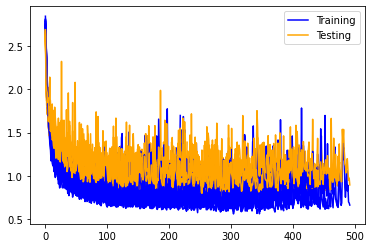

In [32]:
for i, history in enumerate(histories):
    pl.plot(history.history['loss'], label='Training', color="blue")
    pl.plot(history.history['val_loss'], label='Testing', color="orange")
    
    if i == 0:
        pl.legend()
        
    pl.grid()

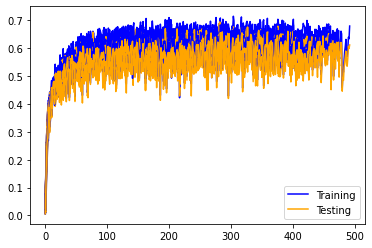

In [33]:
for i, history in enumerate(histories):
    pl.plot(history.history['f1_score_train'], label='Training', color="blue")
    pl.plot(history.history['f1_score_val'], label='Testing', color="orange")
    
    if i == 0:
        pl.legend()
        
    pl.grid()

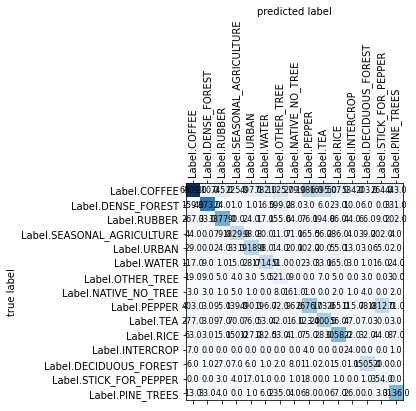

In [37]:
plot_confusion_matrix(conf_matrix, labels)

In [41]:
recall, precision, fscore = recall_precision_fscore_from_confusion_matrix(conf_matrix)

print("Precisions: ", precision)
print("Mean precision: ", np.mean(precision))
print("\nRecalls: ", recall)
print("Mean recall: ", np.mean(recall))
print("\nF-Score: ", fscore)
print("Mean f-score: ", np.mean(fscore))

Precisions:  [0.82874878 0.92291667 0.75094507 0.71111975 0.5835108  0.5439543
 0.18040166 0.20175439 0.50196961 0.52015605 0.66608582 0.02843602
 0.77258727 0.12557645 0.72324723]
Mean precision:  0.5374273245414679

Recalls:  [0.41508169 0.80148026 0.71789966 0.61623989 0.80050083 0.77909091
 0.84032258 0.83854167 0.40035907 0.72727273 0.76834171 0.66666667
 0.93362283 0.885      0.87208009]
Mean recall:  0.7375000386938003

F-Score:  [0.55312754 0.85792254 0.73405065 0.66028881 0.6749956  0.64062792
 0.29703535 0.32525253 0.4454432  0.60652009 0.71356901 0.05454545
 0.84550562 0.21994408 0.79072113]
Mean f-score:  0.5613033003996303
